In [1]:
try:
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from stargazer.stargazer import Stargazer
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    from sklearn.neural_network import MLPRegressor
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    from causalinference import CausalModel as CM
    from statsmodels.sandbox.regression.gmm import IV2SLS
    from linearmodels.panel.model import PanelOLS
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import lightgbm
    from econml.grf import CausalForest, CausalIVForest, RegressionForest
    from lightgbm import LGBMRegressor
    from sklearn.linear_model import LogisticRegression
    from statsmodels.discrete.discrete_model import Logit
    

except ModuleNotFoundError:
    !pip install ISLP -q
    !pip install stargazer -q
    !pip install xgboost -q
    !pip install doubleml -q
    !pip install dowhy -q
    !pip install linearmodels -q
    !pip install lightgbm -q
    !pip install econml -q
    !pip install causalinference -q
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from stargazer.stargazer import Stargazer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    from causalinference import CausalModel as CM
    from statsmodels.sandbox.regression.gmm import IV2SLS
    from linearmodels.panel.model import PanelOLS
    import warnings
    from econml.grf import CausalForest, CausalIVForest, RegressionForest
    import lightgbm
    from lightgbm import LGBMRegressor
    from sklearn.linear_model import LogisticRegression
    from statsmodels.discrete.discrete_model import Logit
    warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_loc = "spillovers.dta"

data = pd.read_stata(data_loc, iterator=True)

In [3]:
#data.variable_labels()

In [4]:
vars_of_int = ['i','year','rmkvaf','grd','grd_k1','rxrd','gspillsic','gspilltec','pat_count','pat_cite','rsales',
              'rppent','emp','gspilltecIV','gspillsicIV','sic2']

data = pd.read_stata(data_loc)
df = data[vars_of_int]
df.columns

Index(['i', 'year', 'rmkvaf', 'grd', 'grd_k1', 'rxrd', 'gspillsic',
       'gspilltec', 'pat_count', 'pat_cite', 'rsales', 'rppent', 'emp',
       'gspilltecIV', 'gspillsicIV', 'sic2'],
      dtype='object')

In [5]:
# convert categorical columns to strings
df['year'] = df['year'].astype(str)
df['i'] = df['i'].astype(str)

C:\Users\marti\AppData\Local\Temp\ipykernel_80484\3340598184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(str)
C:\Users\marti\AppData\Local\Temp\ipykernel_80484\3340598184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = df['i'].astype(str)


In [6]:
var_of_int_noindex = ['rmkvaf','gspilltec','gspilltecIV','gspillsic','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']

# filter dataframe to variables of interest
df = df.drop(columns=['grd','grd_k1','pat_cite'])

# delete NaN values
df = df.dropna(axis=0)

# convert SIC code to string - prev count value 13385
df['sic2'] = df['sic2'].astype(int).astype(str)

df_sum_stats = df[var_of_int_noindex].describe()
df_sum_stats = df_sum_stats.round(2)
df_sum_stats

rmkvaf  gspilltec  gspilltecIV  gspillsic  gspillsicIV  pat_count  \
count   13385.00   13385.00     13385.00   13385.00     13385.00   13385.00   
mean     3863.04   25038.02     21341.64    6417.87      6164.57      16.85   
std     16402.81   19853.42     16288.44   10048.77      9019.92      75.96   
min         0.43     215.84       230.28       0.00         4.31       0.00   
25%        88.34   10263.93      8991.68     496.51       607.00       0.00   
50%       409.62   19842.60     17508.95    1991.19      2067.49       1.00   
75%      1990.41   34880.48     29810.46    7823.23      7534.20       5.00   
max    485566.69  124324.95     92324.67   70175.56     55576.60    2405.00   

          rsales    rppent       emp      rxrd  
count   13385.00  13385.00  13385.00  13385.00  
mean     2852.77   1309.39     18.68    106.59  
std      8782.54   4070.72     53.65    473.90  
min         1.08      0.91      0.10      0.00  
25%       117.32     27.22      1.09      0.00  
50%       450.26    121.87      3.85      4.68  
75%      1950.00    731.75     14.00     30.19  
max    140609.58  72825.98    876.80   8900.00

In [7]:
#df_sum_stats.T.to_excel("sum_stats.xlsx") # export summary statistics
print(df_sum_stats.T.to_latex(float_format="%.2f",columns=['count','mean','std','min','max']))

\begin{tabular}{lrrrrr}
\toprule
 & count & mean & std & min & max \\
\midrule
rmkvaf & 13385.00 & 3863.04 & 16402.81 & 0.43 & 485566.69 \\
gspilltec & 13385.00 & 25038.02 & 19853.42 & 215.84 & 124324.95 \\
gspilltecIV & 13385.00 & 21341.64 & 16288.44 & 230.28 & 92324.67 \\
gspillsic & 13385.00 & 6417.87 & 10048.77 & 0.00 & 70175.56 \\
gspillsicIV & 13385.00 & 6164.57 & 9019.92 & 4.31 & 55576.60 \\
pat_count & 13385.00 & 16.85 & 75.96 & 0.00 & 2405.00 \\
rsales & 13385.00 & 2852.77 & 8782.54 & 1.08 & 140609.58 \\
rppent & 13385.00 & 1309.39 & 4070.72 & 0.91 & 72825.98 \\
emp & 13385.00 & 18.68 & 53.65 & 0.10 & 876.80 \\
rxrd & 13385.00 & 106.59 & 473.90 & 0.00 & 8900.00 \\
\bottomrule
\end{tabular}



## Final data setup for templating with other models

In [8]:
# copy df for standard templating
df_t = df.copy()

# convert monetary values to logs
mon_vars = ['rsales','rmkvaf','rxrd','rppent','gspillsicIV','gspilltecIV','emp']

for var in mon_vars:
    df_t[var] = np.log(df[var]+1)

# create dummy variables and references to their sets
ind_fes = pd.get_dummies(df_t['sic2'], prefix="ife").astype(int).drop('ife_37',axis=1) # drop ref categories
yr_fes = pd.get_dummies(df_t['year'], prefix="yr").astype(int).drop('yr_1980',axis=1)

df_t = pd.concat([df_t, ind_fes, yr_fes], axis=1)

# save fe lists for later reference
ind_fes = list(ind_fes.columns)
yr_fes = list(yr_fes.columns)

# Density plot of the data

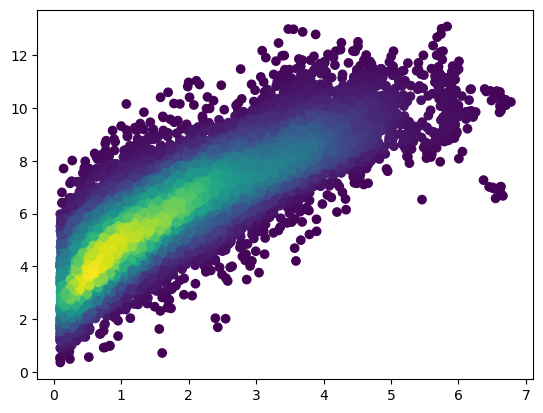

In [9]:
from scipy.stats import gaussian_kde

# logged scatter
x = np.log(df['emp']+1)
y = np.log(df['rmkvaf']+1)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x=x, y=y, c=z)

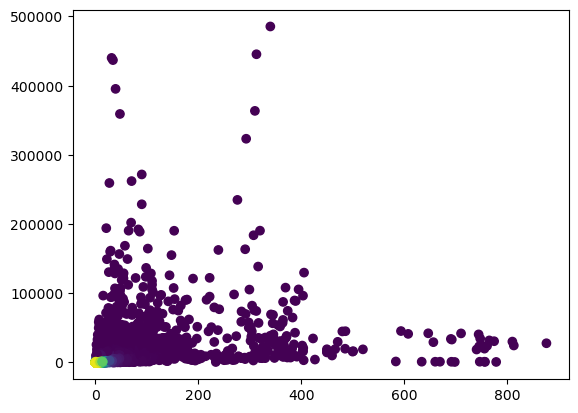

In [10]:
# levels scatter
x = df['emp']
y = df['rmkvaf']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x=x, y=y, c=z)

In [11]:
# scatter density plots reveal that log-log specs better shape the data for monetary  and employment variables

# OLS Regression

In [12]:
# # Run linear model
# # gen fixed effects
# time_effects = pd.get_dummies(df['year'])
# #time_effects.columns = time_effects.columns.astype(str)
# firm_effects = pd.get_dummies(df['i'])
# #time_effects.columns = time_effects.columns.astype(str)

# # set up panel data for PanelOLS
# df_pl = df
# df_pl['year'] = df_pl['year'].astype(int)
# df_pl = df_pl.set_index(['i','year'])

# df = pd.merge(df, time_effects, left_on=df.index, right_on=time_effects.index, how='left')

# df = df.rename(columns={'key_0': 'old_key'})

# df = pd.merge(df, firm_effects, left_on=df['old_key'], right_on=firm_effects.index, how='left')

# fixed_effects = list(time_effects.columns.values)
# for col in firm_effects.columns.values:
#     fixed_effects.append(col)
    
# # remove ref categories
# #fixed_effects.remove('9999.0')
# fixed_effects.remove('1980')

# y_var = df['rmkvaf']

# # get df for x vars + fixed effects
# x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd','gspilltec','gspillsic']
# for col in fixed_effects:
#     x_vars.append(col)



# x_vars = df[x_vars]
# x_vars = sm.add_constant(x_vars)
# x_vars = x_vars.astype(float) # converts categorical booleans to floats

In [26]:
# VARIABLE SELECTION FOR FUTURE MODELS

y = 'rmkvaf'
X = ['rxrd', 'pat_count', 'rsales', 'rppent', 'emp'] # add spillovers later for comparison


df_pl = df_t.copy()
df_pl['year'] = df_pl['year'].astype(int)
df_pl = df_pl.set_index(['i','year'])

In [27]:
# Panel estimate - no industry FE's (absorption errors)

lin_reg = PanelOLS(df_pl[y],sm.add_constant(df_pl[X + ['gspillsicIV','gspilltecIV']]),entity_effects=True,time_effects=True).fit(cov_type='robust')
lin_regtec = PanelOLS(df_pl[y],sm.add_constant(df_pl[X + ['gspilltecIV']]),entity_effects=True,time_effects=True).fit(cov_type='robust')
lin_regsic = PanelOLS(df_pl[y],sm.add_constant(df_pl[X + ['gspillsicIV']]),entity_effects=True,time_effects=True).fit(cov_type='robust')

In [28]:
# Panel estimate - industry FEs + time effects (no individual FEs)
lin_reg2 = PanelOLS(df_pl[y],sm.add_constant(df_pl[X + ind_fes + ['gspillsicIV','gspilltecIV']]),time_effects=True).fit(cov_type='robust')
lin_regtec2 = PanelOLS(df_pl[y],sm.add_constant(df_pl[X + ind_fes + ['gspilltecIV']]),time_effects=True).fit(cov_type='robust')
lin_regsic2 = PanelOLS(df_pl[y],sm.add_constant(df_pl[X + ind_fes + ['gspillsicIV']]),time_effects=True).fit(cov_type='robust')

In [29]:
# #lin_reg = sm.OLS(y_var,x_vars.drop(columns=['gspilltec','gspillsic'])).fit(cov_type='HC0')
# #lin_regtec = sm.OLS(y_var,x_vars.drop(columns=['gspillsicIV','gspillsic'])).fit(cov_type='HC0')
# #lin_regsic = sm.OLS(y_var,x_vars.drop(columns=['gspilltecIV','gspilltec'])).fit(cov_type='HC0')
# panel_y = df_pl['rmkvaf']
# panel_x = df_pl.drop(columns=['gspillsic','gspilltec','rmkvaf'])

# lin_reg = PanelOLS(panel_y,panel_x,entity_effects=True,time_effects=True).fit(cov_type='robust')
# lin_regtec = PanelOLS(panel_y,panel_x.drop(columns='gspillsicIV'),entity_effects=True,time_effects=True).fit(cov_type='robust')
# lin_regsic = PanelOLS(panel_y,panel_x.drop(columns='gspilltecIV'),entity_effects=True,time_effects=True).fit(cov_type='robust')

In [30]:
# 2SLS robustness check
iv_reg = IV2SLS(df_pl[y],df_pl[X + ind_fes + yr_fes + ['gspillsic','gspilltec']],
                   instrument=df_pl[X + ind_fes + yr_fes + ['gspillsicIV','gspilltecIV']]).fit()
iv_regtec = IV2SLS(df_pl[y],df_pl[X + ind_fes + yr_fes + ['gspilltec']],
                   instrument=df_pl[X + ind_fes + yr_fes + ['gspilltecIV']]).fit()
iv_regsic = IV2SLS(df_pl[y],df_pl[X + ind_fes + yr_fes + ['gspillsic']],
                   instrument=df_pl[X + ind_fes + yr_fes + ['gspillsicIV']]).fit()

In [31]:
# export results, omit fixed effects UPDATE WITH NEW DEC 14 PANELS
stargazer = Stargazer([lin_regtec,lin_regtec2,iv_regtec,lin_regsic,lin_regsic2,iv_regsic,lin_reg,lin_reg2,iv_reg])

main_vars = X + ['gspilltec','gspilltecIV','gspillsic','gspillsicIV']
cov_labels = {'rmkvaf': 'Market Value',
             'pat_count': 'Patent Count',
             'rsales': 'Sales',
             'rppent': 'Capital',
             'emp': 'Employment',
             'rxrd': 'R&D Expenditures',
             'gspilltec': 'Tech. Spillovers',
             'gspilltecIV': "Tech. Spillovers (Instrumented)",
             'gspillsic': 'Prod. Market Spillovers',
             'gspillsicIV': 'Prod. Market Spillovers (Instrumented)'}


stargazer.covariate_order(main_vars)
stargazer.custom_columns(['Panel', 'Panel','2SLS', 'Panel', 'Panel','2SLS', 'Panel', 'Panel','2SLS',], [1, 1, 1, 1, 1, 1, 1, 1, 1])
stargazer.add_line("Firm & Time Effects", ['Yes','No','Yes','Yes','No','Yes','Yes','No','Yes'])
stargazer.add_line("Industry & Time Effects", ['No','Yes','No','No','Yes','No','No','Yes','No'])
stargazer.significant_digits(4)
stargazer.rename_covariates(cov_labels)
stargazer

In [32]:
# render to latex
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{9}{c}{\textit{Dependent variable: rmkvaf}} \
\cr \cline{2-10}
\\[-1.8ex] & \multicolumn{1}{c}{Panel} & \multicolumn{1}{c}{Panel} & \multicolumn{1}{c}{2SLS} & \multicolumn{1}{c}{Panel} & \multicolumn{1}{c}{Panel} & \multicolumn{1}{c}{2SLS} & \multicolumn{1}{c}{Panel} & \multicolumn{1}{c}{Panel} & \multicolumn{1}{c}{2SLS}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \\
\hline \\[-1.8ex]
 R&D Expenditures & 0.0227$^{**}$ & 0.1581$^{***}$ & 0.1718$^{***}$ & 0.0218$^{*}$ & 0.1396$^{***}$ & 0.1378$^{***}$ & 0.0217$^{*}$ & 0.1483$^{***}$ & 0.1595$^{***}$ \\
& (0.0113) & (0.0068) & (0.0076) & (0.0113) & (0.0067) & (0.0066) & (0.0113) & (0.0068) & (0.0079) \\
 Patent Count & -0.0007$^{***}$ & -0.0005$^{***}$ & -0.0004$^{***}$ & -0.0007$^{***}$ & -0.0005$^{***}$ & -0.0005$^{***}$ & -0.0007$^{***}$ & -0.0005$^{***}$ & -0.0004$^{***}$ \\
& (0.000

# Ridge Regression

In [33]:
## CODE FOR ML MODELS BASED ON IMPLEMENTATION IN ISLP
# Note: Due to memory constraints on the UofT cloud server, I have commented out code for ML models
# not used in Project 1 so I could still output necessary tables and figures.

# design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns])).fit(df)
# NOTE: including all of the fixed effects seems to kill the notebook. Running Ridge/LASSO on subset excluding FE's

# Check: outlier in dataset driving a split in reg tree.
## Drop two outlier firms: i = 5047, i = 12141, i = 6008
# df = df.loc[(df['i'] != '5047.0') & (df['i'] != '12141.0') & (df['i'] != '6008.0')]

y = 'rmkvaf'
X = ['rxrd', 'pat_count', 'rsales', 'rppent', 'emp','gspilltecIV','gspillsicIV']

design = MS(X).fit(df_t)
Y = np.array(df_t[y])
X = design.transform(df_t)

D = design.fit_transform(df_t)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [34]:
design

ModelSpec(terms=['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspilltecIV',
                 'gspillsicIV'])

In [35]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = lm.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277321.0111165644, tolerance: 55.464202588929275
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: O

In [36]:
soln_path_ridge = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path_ridge.index.name = 'negative log(lambda)'

var_titles = {
    'rxrd': 'R&D Exp\'s',
    'gspillsic': 'Product Mkt Spillovers',
    'gspilltec': 'Technology Spillovers',
    'pat_count': 'Patent Count',
    'rsales': 'Sales',
    'rppent': 'Capital',
    'emp': 'Employment',
    'gspilltecIV': 'Technology Spillovers (IV)',
    'gspillsicIV': 'Product Mkt Spillovers (IV)'
}
soln_path_ridge = soln_path_ridge.rename(columns=var_titles)
soln_path_ridge

R&D Exp's  Patent Count         Sales       Capital  \
negative log(lambda)                                                           
-17.662749            2.672712e-08  1.368240e-08  4.070167e-08  3.991783e-08   
-17.430165            3.372580e-08  1.726523e-08  5.135968e-08  5.037059e-08   
-17.197580            4.255714e-08  2.178625e-08  6.480856e-08  6.356047e-08   
-16.964996            5.370101e-08  2.749113e-08  8.177913e-08  8.020421e-08   
-16.732412            6.776299e-08  3.468987e-08  1.031936e-07  1.012062e-07   
...                            ...           ...           ...           ...   
 4.432765             2.735687e-01 -3.746134e-02  1.083589e+00  7.423604e-01   
 4.665349             2.737592e-01 -3.735912e-02  1.102929e+00  7.406966e-01   
 4.897933             2.739025e-01 -3.724155e-02  1.119376e+00  7.390002e-01   
 5.130518             2.740101e-01 -3.712312e-02  1.133189e+00  7.373854e-01   
 5.363102             2.740908e-01 -3.701212e-02  1.144666e+00  7.359169e-01   

                        Employment  Technology Spillovers (IV)  \
negative log(lambda)                                             
-17.662749            3.783687e-08                1.369281e-08   
-17.430165            4.774471e-08                1.727836e-08   
-17.197580            6.024700e-08                2.180282e-08   
-16.964996            7.602308e-08                2.751204e-08   
-16.732412            9.593025e-08                3.471625e-08   
...                            ...                         ...   
 4.432765            -2.050078e-02               -4.545785e-02   
 4.665349            -3.682027e-02               -4.627462e-02   
 4.897933            -5.051943e-02               -4.691997e-02   
 5.130518            -6.189955e-02               -4.742937e-02   
 5.363102            -7.127074e-02               -4.783132e-02   

                      Product Mkt Spillovers (IV)  
negative log(lambda)                               
-17.662749                           7.614957e-09  
-17.430165                           9.608986e-09  
-17.197580                           1.212516e-08  
-16.964996                           1.530022e-08  
-16.732412                           1.930669e-08  
...                                           ...  
 4.432765                            1.097017e-01  
 4.665349                            1.094422e-01  
 4.897933                            1.091997e-01  
 5.130518                            1.089822e-01  
 5.363102                            1.087926e-01  

[100 rows x 7 columns]

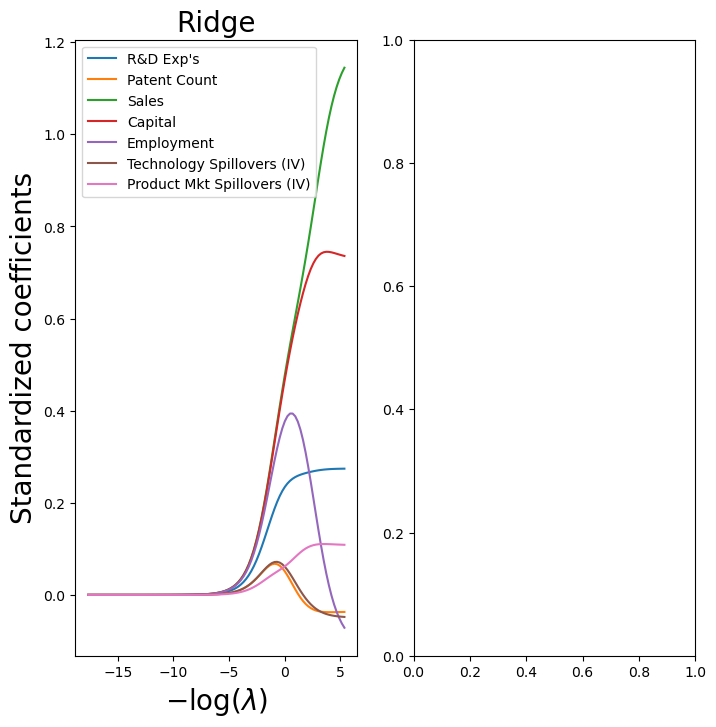

In [39]:
# path_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
# soln_path_ridge.plot(ax=ax1, legend=False)
# ax1.set_xlabel('$-\log(\lambda)$', fontsize=20)
# ax1.set_ylabel('Standardized coefficients', fontsize=20)
# ax1.legend(loc='upper left')
# ax1.set_title('Ridge', fontsize=20)

# # save figure
# plt.savefig('ridge_coef.png')

## Cross-Validation plot

In [40]:
# THIS CHUNK TAKES FOREVER TO RUN
# Using K-fold CV w/ K=5
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)
ridge = lm.ElasticNet(alpha=lambdas[59], l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error') 
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

ridgeCV = lm.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

tuned_ridge = pipeCV.named_steps['ridge']

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.426e+04, tolerance: 4.851e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.435e+04, tolerance: 4.871e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

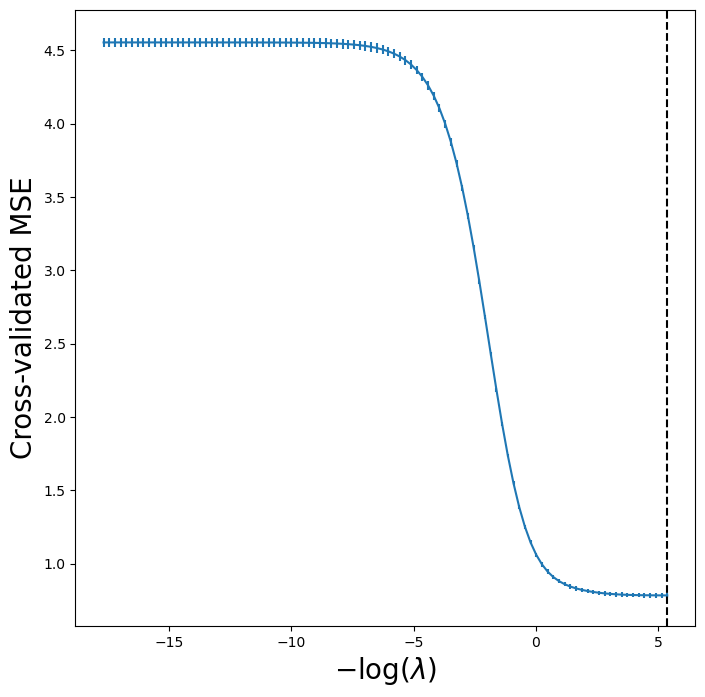

In [41]:
# Plot results
ridge_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
#ax.set_ylim([80000000,220000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('ridge_cv.png')

# LASSO Regression

In [42]:
lassoCV = lm.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

In [43]:
lambdas, soln_array = lm.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

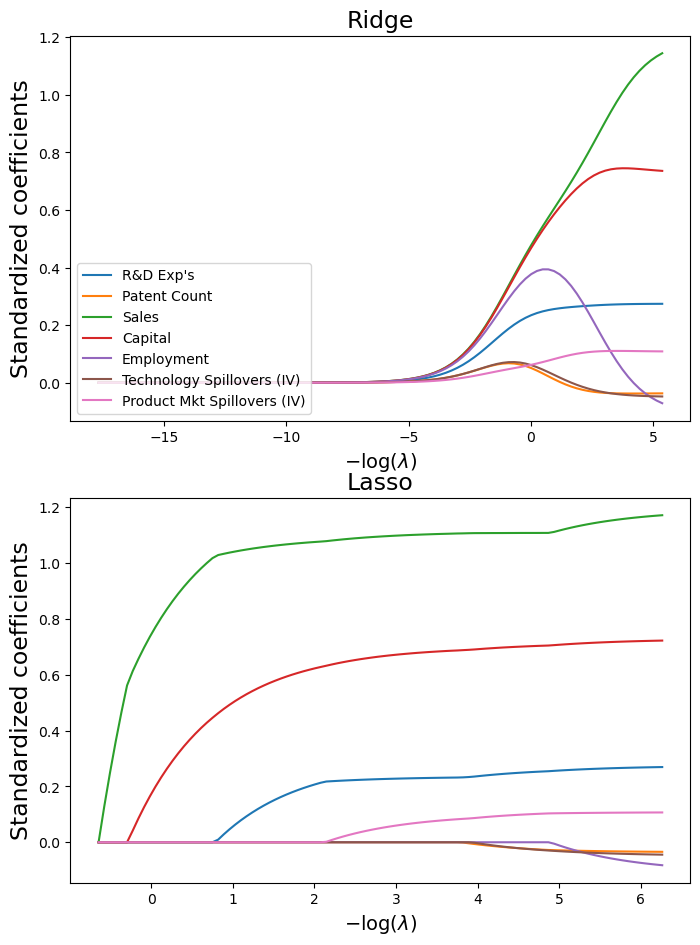

In [44]:
#path_fig, ax = plt.subplots(figsize=(10,5))
path_fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,11))

soln_path_ridge.plot(ax=ax1, legend=False)
ax1.set_xlabel('$-\log(\lambda)$', fontsize=14)
ax1.set_ylabel('Standardized coefficients', fontsize=17)
ax1.legend(loc='lower left')
ax1.set_title('Ridge', fontsize=17)

soln_path.plot(ax=ax2, legend=False)
#ax2.legend(loc='upper left')
ax2.set_xlabel('$-\log(\lambda)$', fontsize=14)
ax2.set_ylabel('Standardized coefficients', fontsize=17)
ax2.set_title('Lasso', fontsize=17)

# save figure
# plt.savefig('lasso_coef.png')
plt.savefig('lasso_ridge_coefs.png',bbox_inches='tight')

## Cross-Validation plot

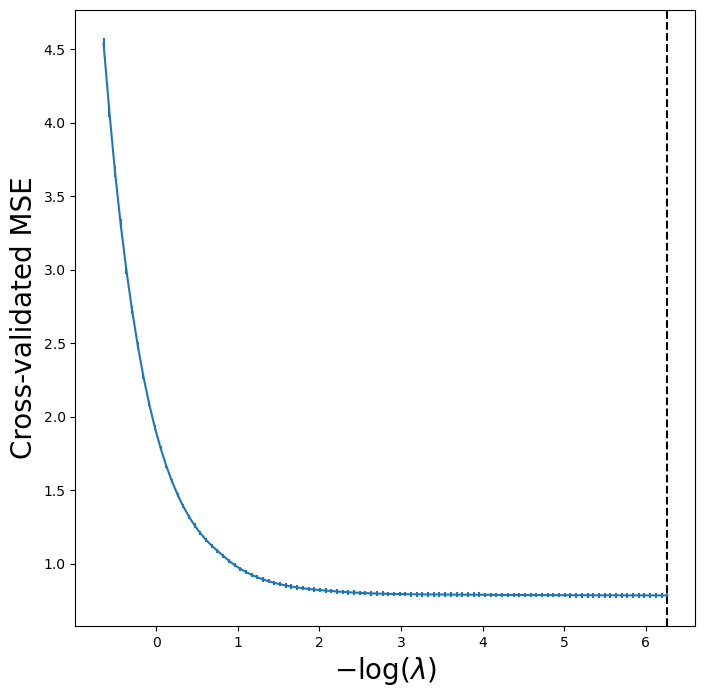

In [45]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('lasso_cv.png')

In [35]:
# # comparing lambdas

# # tuned alphas
# print("LASSO: ", tuned_lasso.alpha_)
# print("Ridge: ", tuned_ridge.alpha_)

In [36]:
# print(-np.log(tuned_lasso.alpha_))

# Regression Tree

In [47]:
# Splitting sample
y = 'rmkvaf'
#X = ['rxrd', 'pat_count', 'rsales', 'rppent', 'emp','gspilltecIV','gspillsicIV']

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df_t[y],
                                test_size=0.3,
                                random_state=0)
feature_names = list(D.columns)

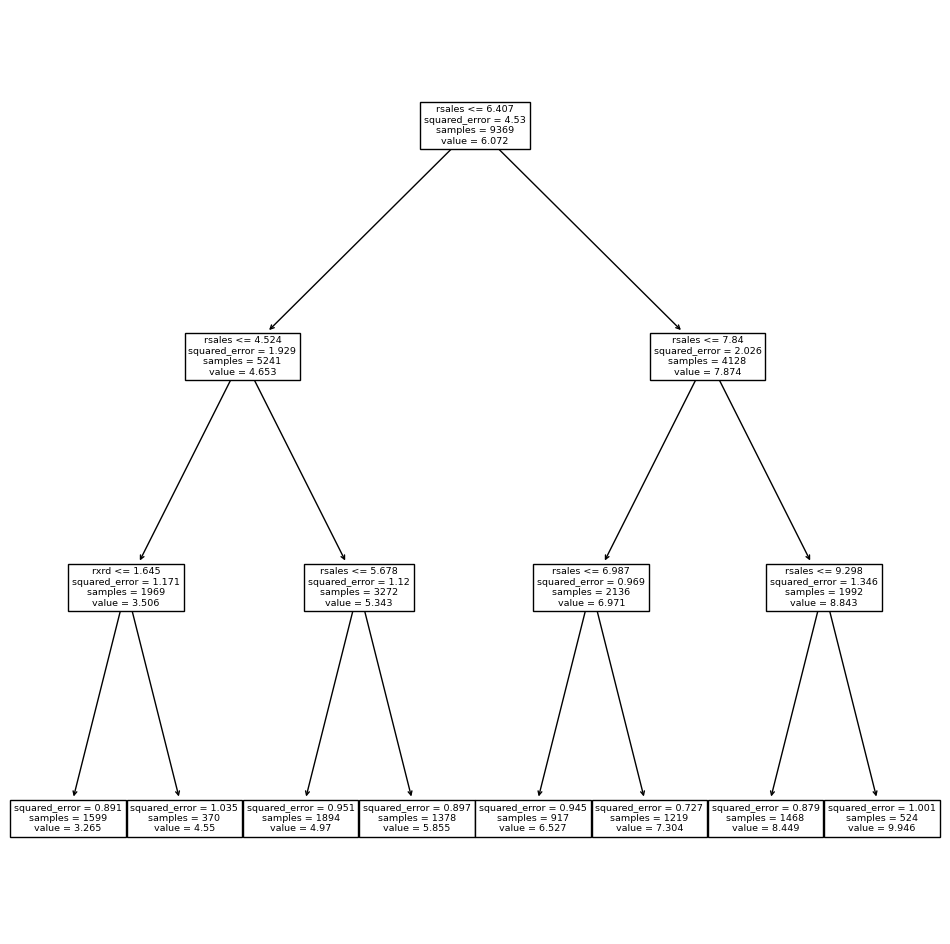

In [51]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [52]:
# Find best pruning for tree
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, # retrains on best alpha
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [53]:
# Get prediction error
best_ = grid.best_estimator_
tree_mse = np.mean((y_test - best_.predict(X_test))**2)
tree_mse

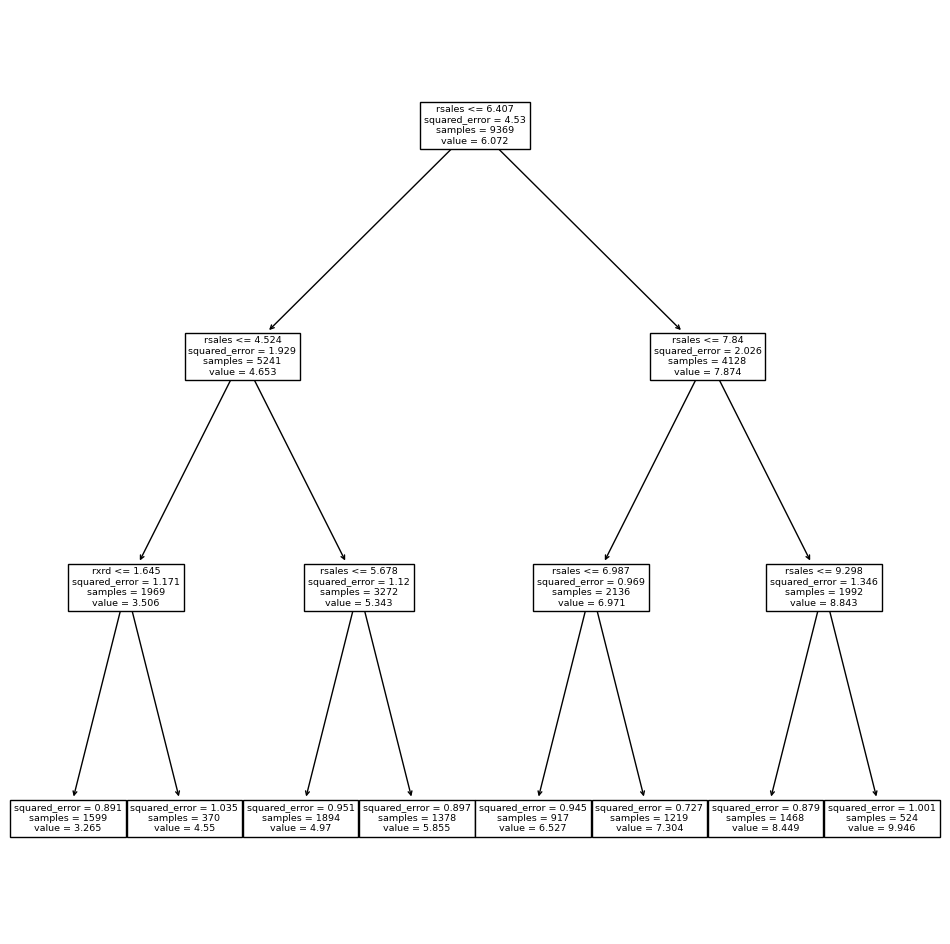

In [54]:
# Output pruned Regression Tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
plt.savefig("pruned_tree.png")

# Random Forest

In [55]:
# add X-train, y-train here with df template
y = 'rmkvaf'
X = ['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspillsicIV', 'gspilltecIV']

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df_t[X + ind_fes + yr_fes],
                                df_t[y],
                                test_size=0.3,
                                random_state=0)

feature_names = list(X_train.columns)

RF_tree = RF(max_features=3, # Random forest model
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_tree.predict(X_test)
rf_mse = np.mean((y_test - y_hat_RF)**2)
rf_mse

In [56]:
feature_imp = pd.DataFrame(
    {'importance':RF_tree.feature_importances_},
    index=feature_names) # Must include feature importance in report
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

# drop FE variable ests for cleaner table
feature_imp = feature_imp.loc[~(feature_imp.index.str.contains('ife') | feature_imp.index.str.contains('yr')),]

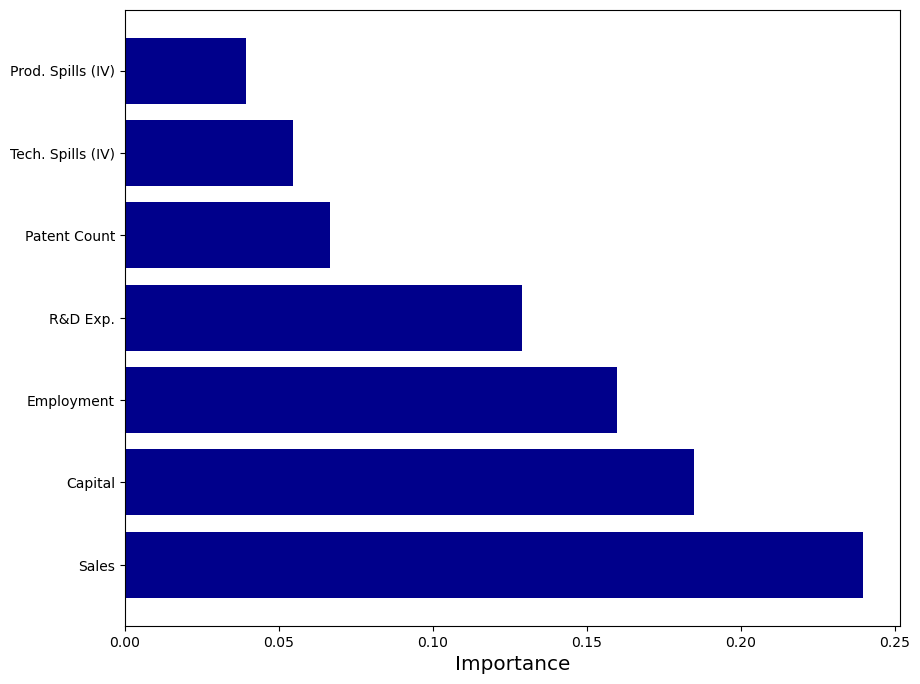

In [57]:
# print(feature_imp.sort_values(by='importance', ascending=False).to_latex()) # print latex output

# Change to full variable names
var_dict = {
    'rxrd': 'R&D Exp.',
    'rsales': 'Sales',
    'rppent': 'Capital',
    'emp': 'Employment',
    'gspillsic': 'Prod. Spills',
    'gspilltec': 'Tech. Spills',
    'gspillsicIV': 'Prod. Spills (IV)',
    'gspilltecIV': 'Tech. Spills (IV)',
    'pat_count': 'Patent Count'
    
}

feature_imp = feature_imp.rename(index=var_dict)

# plot importance values
fig = plt.figure(figsize=(10,8))

#plt.barh(feature_imp.index, feature_imp.importance, color ='darkblue', 
#        width = 0.4)

plt.barh(feature_imp.index, feature_imp.importance, color ='darkblue')


plt.xlabel('Importance', fontsize='x-large')
#plt.title('Importance of Random Forest Regressors for Firm Market Value')

plt.savefig('RFimp.png')

# Bagging

In [45]:
bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=79, random_state=0)

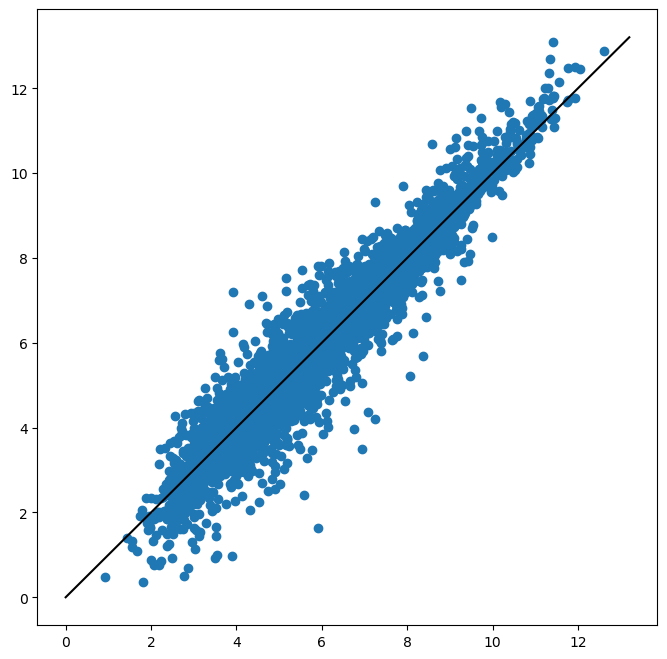

In [46]:
ax = plt.subplots(figsize=(8,8))[1]
y_hat_bag = bag.predict(X_test)
ax.scatter(y_hat_bag, y_test)
x_ax = [0,np.max(ax.get_xlim())]
ax.plot(x_ax, x_ax, color='black')
bag_mse = np.mean((y_test - y_hat_bag)**2)
bag_mse

# Boosting

In [47]:
boost = GBR(n_estimators=500, # Gradient Boosting Regressor
                    learning_rate=0.001,
                    max_depth=3,
                    random_state=0)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=500, random_state=0)

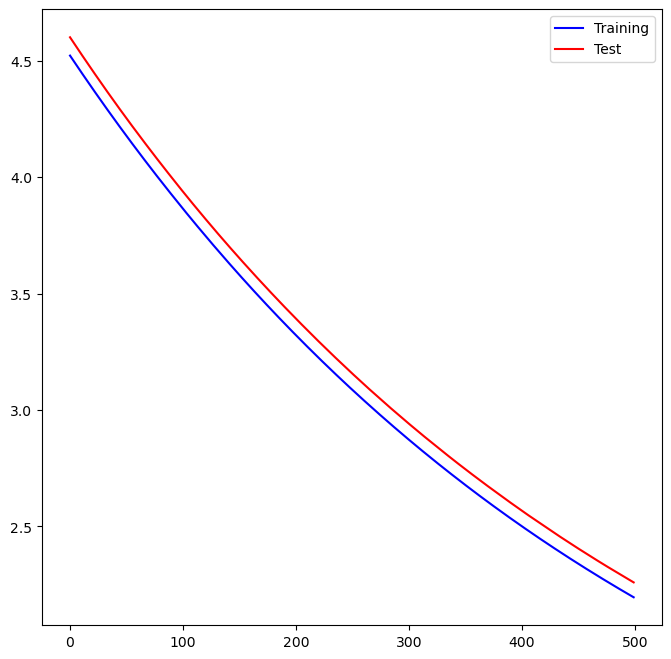

In [48]:
test_error = np.zeros_like(boost.train_score_)
for idx, y_ in enumerate(boost.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost.train_score_.shape[0])
ax = plt.subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

boost_mse = min(test_error)

Mean Squared Error: 1.1436412
Prev. MSE: 40865396.0


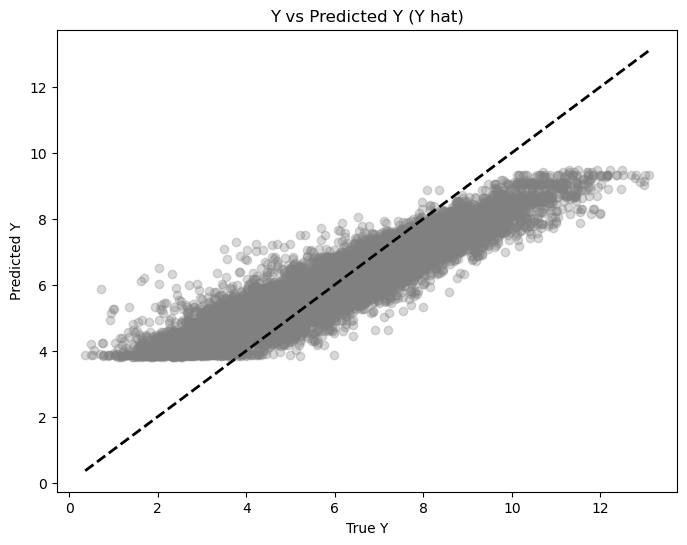

In [49]:
# XG Boost
y = 'rmkvaf'
# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(df_t[X + ind_fes + yr_fes], label=df_t[y])

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round= 10)

# Make predictions 
y_pred = model.predict(dtrain)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(df_t[y], y_pred)
print("Mean Squared Error:", mse)
print("Prev. MSE: 40865396.0")

plt.figure(figsize=(8, 6))
plt.scatter(df_t[y], y_pred, c='grey', alpha=0.3)
plt.plot([df_t[y].min(), df_t[y].max()], [df_t[y].min(), df_t[y].max()], 'k--', lw=2)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Y vs Predicted Y (Y hat)')
plt.show()

# Comparing Test Errors

In [50]:
# # Tree
# print('Tree: ', tree_mse)
# # Bag
# print('Bag: ', bag_mse)
# # Random Forest
# print('Random Forest: ', rf_mse)
# # Boost
# print('Boost: ', boost_mse)

# # Make table
# error_tbl = {
#     'model' : ['Tree', 'Bag', 'Random Forest', 'Boost'],
#     'MSE' : [tree_mse, bag_mse, rf_mse, boost_mse]
# }
# error_tbl = pd.DataFrame(data=error_tbl)
# print(error_tbl.to_latex())

# Predicting Market value of spillovers across years

# Impact of spillovers on firm value over time

In [52]:
# Include confidence intervals. Use 2 or 5 year intervals if need more statistical power
# Try with PLR DML to compare results - separate bar i.e. for each year, one OLS bar and one DML bar
# Separate plots for tech/product market spillovers

y = 'rmkvaf'
X = ['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspillsicIV', 'gspilltecIV']

# build year-spillover interaction terms
years = df_t.year.astype(str).sort_values().unique()

years = years[1:] # remove first year as ref category



# for spillover in spillovers:
#     for year in years:
#         col_name = f"{spillover}X{year}"
#         df_t[col_name] = df_t[spillover]*df_t[year]
#         interactions.append(col_name)

# drop reference year dummy
#x_vars = x_vars.drop(columns=['1981'])
#fixed_effects.remove('1981')

In [53]:
# Estimate effect of spillovers on firm value, OLS w/o firm FE's. Estimate spillovers separately, then together.

# Full model
# year_model1 = sm.OLS(y_var,x_vars).fit(cov_type='HC0')
# year_model1.summary()

In [54]:
# # Tech spillovers model, no firm FE's
# drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
# x_vars_nofe = x_vars.drop(columns=fixed_effects)
# x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

# # year_model2 = sm.OLS(y_var,x_vars_nofe).fit(cov_type='HC0')
# # year_model2.summary()

In [55]:
# # Tech spillovers model, firm FE's
# x_vars_fe = x_vars.drop(columns=drop_columns)
# x_vars_fe = x_vars_fe.drop(columns=['gspillsic','gspilltec'])

# df_pl = df_pl.reset_index()
# df_pl['year1'] = df_pl['year'].astype('category')
# df_pl = df_pl.set_index(['i','year'])

# #formula = 'rmkvaf ~ 1 + gspilltecIV + pat_count + rsales + rppent + emp + rxrd + year1*gspilltecIV + EntityEffects'
# #year_model3 = PanelOLS.from_formula(formula, df_pl).fit(cov_type='robust')
# year_model3 = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
# #year_model3.summary()

Results highly depend on the firm FE's. Wrong sign for tech, insignificant for product market. Unobserved firm-related variables play a role?

In [56]:
# # Product spillovers model, no firm FE's
# drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]
# x_vars_nofe = x_vars.drop(columns=fixed_effects)
# x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

# # year_model4 = sm.OLS(y_var,x_vars_nofe).fit(cov_type='HC0')
# # year_model4.summary()

In [57]:
# # Product spillovers model, firm FE's
# x_vars_fe = x_vars.drop(columns=drop_columns)
# x_vars_fe = x_vars_fe.drop(columns=['gspillsic','gspilltec'])

# year_model5 = sm.OLS(y_var,x_vars_fe).fit(cov_type='HC0')
# #year_model5.summary()

In [66]:
# Product Spillovers, all FE's, 5-year intervals

y = 'rmkvaf'
X = ['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspillsicIV', 'gspilltecIV']
spillovers = ['gspilltecIV','gspillsicIV']
interactions = []

# Create 5-year intervals

#df_t['1980_84'] = df_t['year'].isin([1980,1981,1982,1983,1984]) # remove as ref category
df_t['1985_89'] = df_t['year'].isin(['1985','1986','1987','1988','1989']).astype(int)
df_t['1990_94'] = df_t['year'].isin(['1990','1991','1992','1993','1994']).astype(int)
df_t['1995_99'] = df_t['year'].isin(['1995','1996','1997','1998','1999']).astype(int)

intervals = ['1985_89','1990_94','1995_99']

for spillover in spillovers:
    for interval in intervals:
        col_name = f"{spillover}X{interval}"
        df_t[col_name] = df_t[spillover]*df_t[interval]
        interactions.append(col_name)

In [68]:
int_modelsic = sm.OLS(df_t[y],df_t[X + ind_fes + intervals + interactions]).fit(cov_type='HC0')
int_modelsic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rmkvaf   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.817e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                        0.00
Time:                        23:38:17   Log-Likelihood:                         -16324.
No. Observations:               13385   AIC:                                  3.278e+04
Df Residuals:                   13318   BIC:                                  3.328e+04
Df Model:                          67                                                  
Covariance Type:                  HC0                                                  
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
rxrd                    0.1494      0.007     22.363      0.000       0.136       0.162
pat_count              -0.0005   8.05e-05     -5.731      0.000      -0.001      -0.000
rsales                  0.5975      0.020     29.953      0.000       0.558       0.637
rppent                  0.3594      0.014     25.845      0.000       0.332       0.387
emp                    -0.1277      0.019     -6.633      0.000      -0.165      -0.090
gspillsicIV             0.0829      0.009      8.736      0.000       0.064       0.101
gspilltecIV            -0.0659      0.010     -6.649      0.000      -0.085      -0.046
ife_10                  1.0099      0.126      7.984      0.000       0.762       1.258
ife_13                  0.5621      0.068      8.250      0.000       0.429       0.696
ife_14                  0.3510      0.099      3.558      0.000       0.158       0.544
ife_15                  0.7419      0.204      3.639      0.000       0.342       1.141
ife_16                  0.2860      0.141      2.035      0.042       0.011       0.561
ife_17                  0.8364      0.071     11.792      0.000       0.697       0.975
ife_20                  0.8795      0.048     18.242      0.000       0.785       0.974
ife_21                  1.3182      0.077     17.194      0.000       1.168       1.468
ife_22                  0.1531      0.062      2.482      0.013       0.032       0.274
ife_23                  0.5415      0.077      6.991      0.000       0.390       0.693
ife_24                  0.4372      0.080      5.441      0.000       0.280       0.595
ife_25                  0.3321      0.046      7.238      0.000       0.242       0.422
ife_26                  0.3171      0.044      7.162      0.000       0.230       0.404
ife_27                  1.1382      0.053     21.470      0.000       1.034       1.242
ife_28                  0.7398      0.040     18.631      0.000       0.662       0.818
ife_29                  0.0616      0.051      1.199      0.231      -0.039       0.162
ife_30                  0.1940      0.058      3.370      0.001       0.081       0.307
ife_31                  0.4331      0.077      5.630      0.000       0.282       0.584
ife_32                 -0.0574      0.066     -0.874      0.382      -0.186       0.071
ife_33                 -0.1840      0.055     -3.371      0.001      -0.291      -0.077
ife_34                  0.2224      0.042      5.235      0.000       0.139       0.306
ife_35                  0.3383      0.036      9.420      0.000       0.268       0.409
ife_36                  0.4365      0.035     12.310      0.000       0.367       0.506
ife_38                  0.6389      0.039     16.233      0.000       0.562     

## Graphing Product Market Spillovers over time

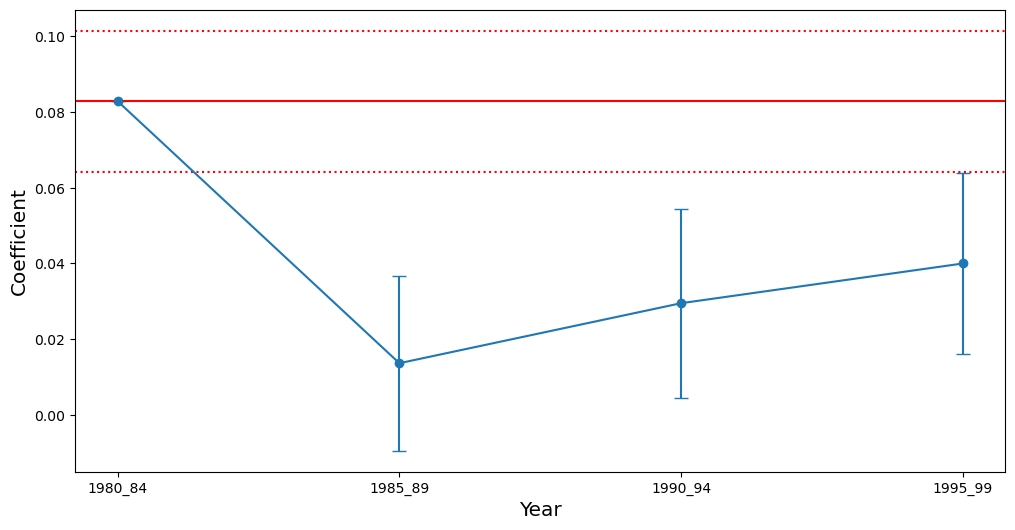

In [76]:
# Plot 5 Year Intervals

ref_year = '1980_84'
time_coefs_sic = {
    'interval': [ref_year] + intervals,
    'coef': [np.nan for i in range(0,len(intervals)+1)],
    'CI_l': [np.nan for i in range(0,len(intervals)+1)],
    'CI_h': [np.nan for i in range(0,len(intervals)+1)],
    'se': [np.nan for i in range(0,len(intervals)+1)]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='interval').reset_index(drop=True)

conf_intervals = int_modelsic.conf_int(alpha=0.05, cols=None)
s_errors = int_modelsic.HC0_se

# grab coefficients and confidence intervals
coef_ref = int_modelsic.params['gspillsicIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspillsicIV',1].values[0]

for interval in time_coefs_sic['interval'].unique():
    if interval == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{interval}"
        coef = int_modelsic.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['interval'] == interval, 'CI_h'] = ci_h


time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['interval'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_sic['interval'],y=time_coefs_sic['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='solid', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('Coefficient', fontsize='x-large')
#plt.title('Effect of Product Market Spillovers, 5-Year Intervals')
#plt.grid(True)
#plt.show()

plt.savefig('sic5yr.png')

## Tech Spillovers over time

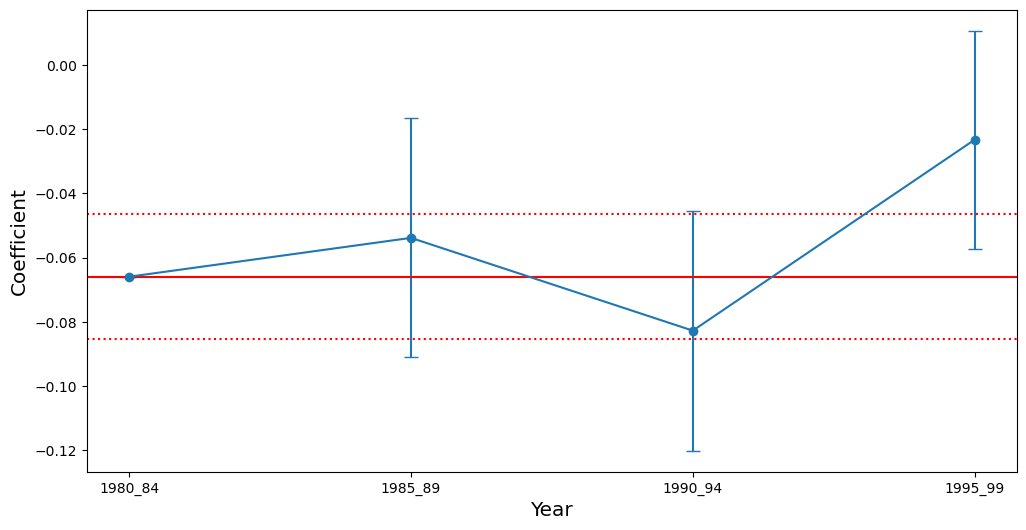

In [75]:
ref_year = '1980_84'
time_coefs_tec = {
    'interval': [ref_year] + intervals,
    'coef': [np.nan for i in range(0,len(intervals)+1)],
    'CI_l': [np.nan for i in range(0,len(intervals)+1)],
    'CI_h': [np.nan for i in range(0,len(intervals)+1)],
    'se': [np.nan for i in range(0,len(intervals)+1)]
}

time_coefs_tec = pd.DataFrame(time_coefs_tec)
time_coefs_tec = time_coefs_tec.sort_values(by='interval').reset_index(drop=True)

conf_intervals = int_modelsic.conf_int(alpha=0.05, cols=None)
s_errors = int_modelsic.HC0_se

# grab coefficients and confidence intervals
coef_ref = int_modelsic.params['gspilltecIV'] # coef for ref year category
l_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',0].values[0] # conf interval for ref cat
h_ref = conf_intervals.loc[conf_intervals.index == 'gspilltecIV',1].values[0]

for interval in time_coefs_tec['interval'].unique():
    if interval == ref_year:
        coef = coef_ref
        ci_l = 0 
        ci_h = 0
        
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspilltecIVX{interval}"
        coef = int_modelsic.params[col_name] + coef_ref
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_ref
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_ref
        
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'coef'] = coef
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_l'] = ci_l
        time_coefs_tec.loc[time_coefs_tec['interval'] == interval, 'CI_h'] = ci_h


time_coefs_tec['upper'] = time_coefs_tec['CI_h'] - time_coefs_tec['coef']
time_coefs_tec['lower'] = time_coefs_tec['coef'] - time_coefs_tec['CI_l']
time_coefs_tec.loc[time_coefs_tec['interval'] == ref_year, ['upper','lower']] = 0

cis = time_coefs_tec[['lower','upper']].T
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=time_coefs_tec['interval'],y=time_coefs_tec['coef'],yerr=cis, capsize=5, marker='o')
plt.axhline(y=coef_ref, linestyle='solid', color='r')
plt.axhline(y=l_ref, linestyle='dotted', color='r')
plt.axhline(y=h_ref, linestyle='dotted', color='r')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('Coefficient', fontsize='x-large')
#plt.title('Effect of Technology Spillovers, 5-Year Intervals')
#plt.grid(True)
#plt.show()

plt.savefig('tec5yr.png')

# Propensity Score Matching/ IPW Model

In [133]:
# Helper fcn for standardizing data for PS model

def std_col(column):
    mean = column.mean()
    stdev = column.std()
    std_column = (column - mean)/stdev

    return std_column

def standardize_df(df, columns: list):
    new_df = df.copy()
    for col in columns:
        new_df[col] = std_col(new_df[col])

    return new_df

In [134]:
y = 'rmkvaf'
X = ['rxrd','pat_count', 'rsales', 'rppent', 'emp'] # add spillovers individually to avoid perfect predictions in PS calc
# X = ['pat_count', 'rsales', 'rppent', 'emp'] # removing rxrd for testing - high correlation with treatment

# ADJUST TREATMENT VARIABLE: Firms where tech spillovers >= 80th percentile
df_t['tec_abv_qtle'] = df_t['gspilltecIV'] > df_t['gspilltecIV'].quantile(0.8)
df_t['tec_abv_qtle'] = df_t['tec_abv_qtle'].astype(int)

df_t['sic_abv_qtle'] = df_t['gspillsicIV'] > df_t['gspillsicIV'].quantile(0.8)
df_t['sic_abv_qtle'] = df_t['sic_abv_qtle'].astype(int)

# standardize all non-binary variables
cols_to_stdize = [X + [y,'gspilltecIV','gspillsicIV']]
std_df_t = standardize_df(df_t,cols_to_stdize)

In [135]:
# Calculate propensity scores

from sklearn.linear_model import LogisticRegression
ps_sic = LogisticRegression(C=1e6, max_iter=2000).fit(y=std_df_t['sic_abv_qtle'], X=sm.add_constant(std_df_t[X + ind_fes + yr_fes]))
ps_tec = LogisticRegression(C=1e6, max_iter=2000).fit(y=std_df_t['tec_abv_qtle'], X=sm.add_constant(std_df_t[X + ind_fes + yr_fes]))

# ps_sic_t = Logit(endog=std_df_t['sic_abv_qtle'], exog=sm.add_constant(std_df_t[X + ind_fes + yr_fes])).fit() #statsmodel fit for diagnosis of coef's
# ps_tec_t = Logit(std_df_t['tec_abv_qtle'], sm.add_constant(std_df_t[X + ind_fes + yr_fes])).fit()

# initialize columns storing prop scores (get KeyError otherwise)
std_df_t['ps_tec'] = 0
std_df_t['ps_sic'] = 0

std_df_t['ps_tec'] = ps_tec.predict_proba(sm.add_constant(std_df_t[X + ind_fes + yr_fes]))
std_df_t['ps_sic'] = ps_sic.predict_proba(sm.add_constant(std_df_t[X + ind_fes + yr_fes]))

# clip extreme propensity scores to 0.05 for treat, 0.95 for untreated (reduces variance but introduces bias)
# df_t.loc[(df_t['tec_abv_qtle'] == 0) & (df_t['ps_tec'] > 0.95), 'ps_tec'] = 0.95
# df_t.loc[(df_t['tec_abv_qtle'] == 1) & (df_t['ps_tec'] < 0.05), 'ps_tec'] = 0.05
# df_t.loc[(df_t['sic_abv_qtle'] == 0) & (df_t['ps_sic'] > 0.95), 'ps_sic'] = 0.95
# df_t.loc[(df_t['sic_abv_qtle'] == 1) & (df_t['ps_sic'] < 0.05), 'ps_sic'] = 0.05

In [136]:
# Observe what are the percentiles of observations with super high pscores
def get_percentile(x, column):
    return (column < x).mean()

std_df_t['pctile_tec'] = std_df_t['gspilltecIV'].apply(get_percentile, column=std_df_t['gspilltecIV'])
std_df_t.loc[(std_df_t['tec_abv_qtle'] == 0) & (std_df_t['ps_tec'] > 0.9),['pctile_tec','tec_abv_qtle','ps_tec']].sort_values(by='pctile_tec')

pctile_tec  tec_abv_qtle    ps_tec
18059    0.000000             0  0.990373
18058    0.000075             0  0.992302
18056    0.000149             0  0.994770
18060    0.000224             0  0.984096
18061    0.000299             0  0.988687
...           ...           ...       ...
14499    0.799178             0  0.935518
58       0.799253             0  0.956416
16202    0.799402             0  0.935695
8942     0.799552             0  0.905053
10101    0.799776             0  0.941468

[6674 rows x 3 columns]

### Positivity Graph

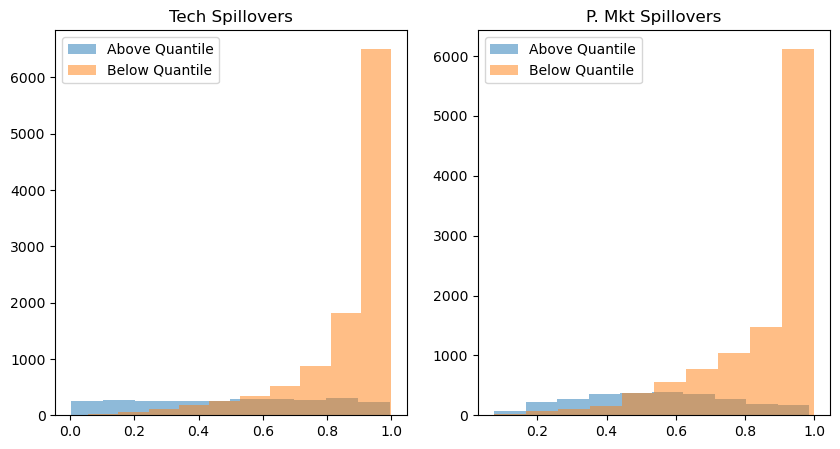

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot 1: positivity graph for gspilltec
ax1.hist(std_df_t.loc[std_df_t.tec_abv_qtle == 1, 'ps_tec'], label='Above Quantile', alpha=0.5)
ax1.hist(std_df_t.loc[std_df_t.tec_abv_qtle == 0, 'ps_tec'], label='Below Quantile', alpha=0.5)
ax1.legend()
ax1.set_title("Tech Spillovers")

# plot 2: positivity graph for gspillsic
ax2.hist(std_df_t.loc[std_df_t.sic_abv_qtle == 1, 'ps_sic'], label='Above Quantile', alpha=0.5)
ax2.hist(std_df_t.loc[std_df_t.sic_abv_qtle == 0, 'ps_sic'], label='Below Quantile', alpha=0.5)
ax2.legend()
ax2.set_title("P. Mkt Spillovers")

plt.savefig('ps_positivity.png', bbox_inches='tight')

Appears best PS model does not include FE's, the opposing spillover variable, or R&D expenditure.

In [138]:
# implement straight-up matching

# Tech. Spillovers
T = 'tec_abv_qtle'

ps_tec = std_df_t['ps_tec'].copy().values # must copy due to byte error down the line if added directly.

cm = CM(
    Y=std_df_t[y].values, 
    D=std_df_t[T].values, 
    X=ps_tec
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.105      0.115     -0.912      0.362     -0.331      0.121
           ATC     -0.110      0.142     -0.775      0.439     -0.389      0.168
           ATT     -0.085      0.071     -1.204      0.229     -0.223      0.053



In [147]:
# Boot-strapping; produce histogram
def matching_bs(data, Y, D, X, samples:int, rdm_state=1):

    # create series storing results
    results = []
    # sample and estimate
    for i in range(0,samples):
        sample = data.sample(frac=0.3, replace=True)
        ps = sample[X].copy().values
        model = CM(Y=sample[Y].values, D=sample[D].values, X=ps)
        model.est_via_matching(matches=1, bias_adj=True)
        ate = model.estimates['matching']['ate']
        results.append(ate)
        
    return results

(array([14., 32., 27., 13.,  4.,  5.,  0.,  3.,  1.,  1.]),
 array([-0.23981619, -0.1845485 , -0.12928081, -0.07401313, -0.01874544,
         0.03652225,  0.09178994,  0.14705763,  0.20232532,  0.25759301,
         0.3128607 ]),
 <BarContainer object of 10 artists>)

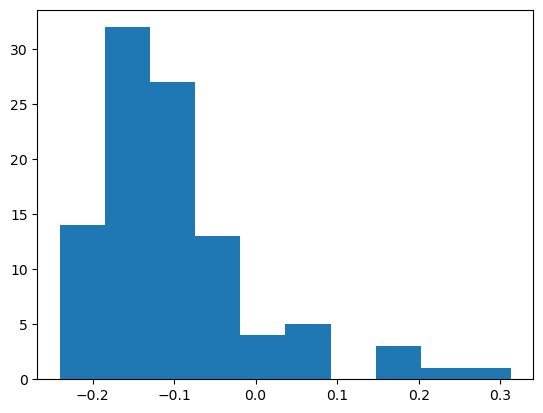

In [148]:
tecmatch_bs = matching_bs(std_df_t, y, T, 'ps_tec', samples=100)
plt.hist(tecmatch_bs)

In [149]:
# Find IPW ATE for tech spillovers

#ps_df = df.drop(df.query("ps_tec<=0.005 | ps_tec>0.995").index, axis=0)

weight_t = 1/std_df_t.query("tec_abv_qtle==1")["ps_tec"]
weight_nt = 1/(1-std_df_t.query("tec_abv_qtle==0")["ps_tec"])
print("Original Sample Size", std_df_t.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

weight = ((std_df_t["tec_abv_qtle"]-std_df_t["ps_tec"]) /
          (std_df_t["ps_tec"]*(1-std_df_t["ps_tec"])))

y1 = sum(std_df_t.query("tec_abv_qtle==1")["rmkvaf"]*weight_t) / len(std_df_t)
y0 = sum(std_df_t.query("tec_abv_qtle==0")["rmkvaf"]*weight_nt) / len(std_df_t)

ate = np.mean(weight * std_df_t["rmkvaf"])
ate_tec_ipw = ate # save results for later output

# Save results in table
results = pd.DataFrame(data = np.array([
    ['Technology', y1, y0, ate],
]),
    columns = ['Spillover','Y1','Y0','ATE'])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Original Sample Size 13385
Treated Population Sample Size 12980.965128119436
Untreated Population Sample Size 2768329.0642748927
Y1: 1.4016512829252243
Y0: 58.00069378893381
ATE -56.599042506008416


## Product Market Spillovers

In [150]:
# Find ATE for product market spillovers

#ps_df = df.drop(df.query("ps_sic<=0.005 | ps_sic>0.995").index, axis=0)

weight_t = 1/std_df_t.query("sic_abv_qtle==1")["ps_sic"]
weight_nt = 1/(1-std_df_t.query("sic_abv_qtle==0")["ps_sic"])
print("Original Sample Size", std_df_t.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

weight = ((std_df_t["sic_abv_qtle"]-std_df_t["ps_sic"]) /
          (std_df_t["ps_sic"]*(1-std_df_t["ps_sic"])))

y1 = sum(std_df_t.query("sic_abv_qtle==1")["rmkvaf"]*weight_t) / len(std_df_t)
y0 = sum(std_df_t.query("sic_abv_qtle==0")["rmkvaf"]*weight_nt) / len(std_df_t)

ate = np.mean(weight * std_df_t["rmkvaf"])
ate_sic_ipw = ate # save results for later output

results.loc[1] = ['Product Market', y1, y0, ate]

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Original Sample Size 13385
Treated Population Sample Size 6158.389252514645
Untreated Population Sample Size 106017109069.69083
Y1: 0.23136410280603045
Y0: -1878486.661440717
ATE 1878486.8928048261


In [151]:
# PM Spillovers Matching
T = 'sic_abv_qtle'

ps_sic = std_df_t['ps_sic'].copy().values # must copy due to byte error down the line if added directly.

cm = CM(
    Y=std_df_t[y].values, 
    D=std_df_t[T].values, 
    X=std_df_t['ps_sic'].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.358      0.452      0.793      0.428     -0.527      1.243
           ATC      0.454      0.564      0.805      0.421     -0.651      1.560
           ATT     -0.027      0.050     -0.547      0.585     -0.125      0.071



(array([ 7.,  7., 13., 26., 17., 13., 10.,  4.,  2.,  1.]),
 array([0.26610085, 0.2906022 , 0.31510355, 0.3396049 , 0.36410626,
        0.38860761, 0.41310896, 0.43761031, 0.46211166, 0.48661301,
        0.51111436]),
 <BarContainer object of 10 artists>)

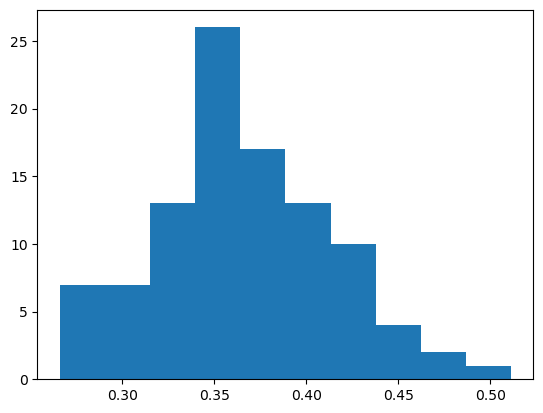

In [152]:
# Boot-strapping; produce histogram
sicmatch_bs = matching_bs(std_df_t, y, T, 'ps_sic', samples=100)
plt.hist(sicmatch_bs)

In [25]:
# Finish output table for report
results[['Y1','Y0','ATE']] = results[['Y1','Y0','ATE']].astype(float)
results = results.set_index('Spillover').round(2)

In [26]:
print(results.to_latex())

\begin{tabular}{lrrr}
\toprule
 & Y1 & Y0 & ATE \\
Spillover &  &  &  \\
\midrule
Technology & 261.140000 & 98.900000 & 162.240000 \\
Product Market & 22693.140000 & 153.530000 & 22539.610000 \\
\bottomrule
\end{tabular}



# Learner Models

In [153]:
# Based on Meta Learner Notebook from Causal Inference for the Brave & True

In [154]:
# import req'd functions - downloaded to my Git folder from CIBT GitHub: https://github.com/matheusfacure/python-causality-handbook/tree/master
from nb21 import cumulative_gain, elast

y = 'rmkvaf'
X = ['gspillsicIV','pat_count','rxrd','rsales','rppent','emp']
T = 'tec_abv_qtle'

# Create Train/Test set
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df_t[X + ['gspilltecIV','sic_abv_qtle',T] + ind_fes + yr_fes ],
                                df_t[y],
                                test_size=0.3,
                                random_state=0)


In [155]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# S-Learner
## Tech. Spillovers

In [156]:
# S-Learner

from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = RF(max_features=12,max_depth=15, random_state=0)
s_learner.fit(X_train[X + ind_fes + yr_fes + [T]], y_train)

RandomForestRegressor(max_depth=15, max_features=12, random_state=0)

In [157]:
s_learner_cate_train = (s_learner.predict(train[X + ind_fes + yr_fes].assign(**{T: 1})) -
                        s_learner.predict(train[X + ind_fes + yr_fes].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X + ind_fes + yr_fes].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X + ind_fes + yr_fes].assign(**{T: 0}))) # predict under control
)

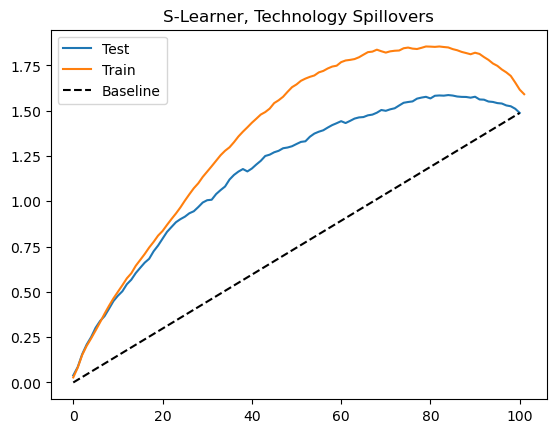

In [158]:
# Plot Gain Curve
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner, Technology Spillovers");

plt.savefig('s-learner_tec.png', bbox_inches='tight')

## Product Market

In [159]:
y = 'rmkvaf'
X = ['gspilltecIV','pat_count','rxrd','rsales','rppent','emp']
T = 'sic_abv_qtle'

In [160]:

np.random.seed(123)
s_learner = RF(max_features=12,max_depth=15, random_state=0)
s_learner.fit(X_train[X + ind_fes + yr_fes + [T]], y_train)

RandomForestRegressor(max_depth=15, max_features=12, random_state=0)

In [161]:
s_learner_cate_train = (s_learner.predict(train[X + ind_fes + yr_fes].assign(**{T: 1})) -
                        s_learner.predict(train[X + ind_fes + yr_fes].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X + ind_fes + yr_fes].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X + ind_fes + yr_fes].assign(**{T: 0}))) # predict under control
)

C:\Users\marti\Documents\GitHub\ECO2425-Causal-ML\nb21.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


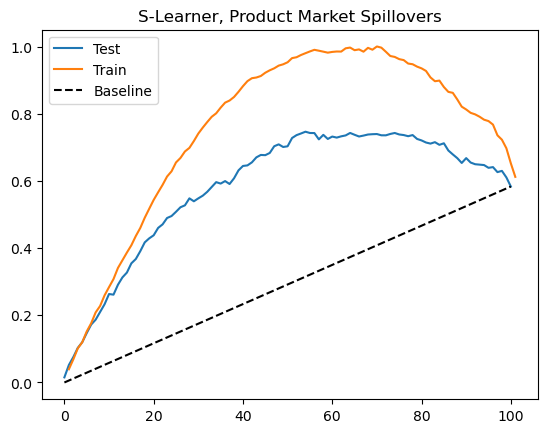

In [162]:
# Plot Gain Curve
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner, Product Market Spillovers");

plt.savefig('s-learner_sic.png', bbox_inches='tight')

# T-Learner

In [163]:
# T-learner

y = 'rmkvaf'
X = ['gspillsicIV','pat_count','rxrd','rsales','rppent','emp']
T = 'tec_abv_qtle'


# m0 = LGBMRegressor(max_depth=10, min_child_samples=60)
# m1 = LGBMRegressor(max_depth=10, min_child_samples=60)

m0 = RF(max_features=12, max_depth=15, random_state=0)
m1 = RF(max_features=12, max_depth=15, random_state=0)

m0.fit(train.query('tec_abv_qtle==0')[X + ind_fes + yr_fes], train.query('tec_abv_qtle==0')[y])
m1.fit(train.query('tec_abv_qtle==1')[X + ind_fes + yr_fes], train.query('tec_abv_qtle==1')[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X + ind_fes + yr_fes]) - m0.predict(train[X + ind_fes + yr_fes])
t_learner_cate_test = test.assign(cate=m1.predict(test[X + ind_fes + yr_fes]) - m0.predict(test[X + ind_fes + yr_fes]))

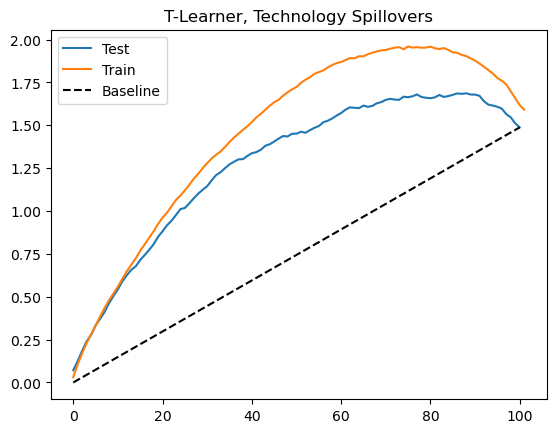

In [164]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner, Technology Spillovers");

plt.savefig('t-learner_tec.png', bbox_inches='tight')

## Product Market Spillovers

In [165]:
y = 'rmkvaf'
X = ['gspilltecIV','pat_count','rxrd','rsales','rppent','emp']
T = 'sic_abv_qtle'

In [166]:

m0 = RF(max_features=12, max_depth=15, random_state=0)
m1 = RF(max_features=12, max_depth=15, random_state=0)

m0.fit(train.query('tec_abv_qtle==0')[X + ind_fes + yr_fes], train.query('tec_abv_qtle==0')[y])
m1.fit(train.query('tec_abv_qtle==1')[X + ind_fes + yr_fes], train.query('tec_abv_qtle==1')[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X + ind_fes + yr_fes]) - m0.predict(train[X + ind_fes + yr_fes])
t_learner_cate_test = test.assign(cate=m1.predict(test[X + ind_fes + yr_fes]) - m0.predict(test[X + ind_fes + yr_fes]))

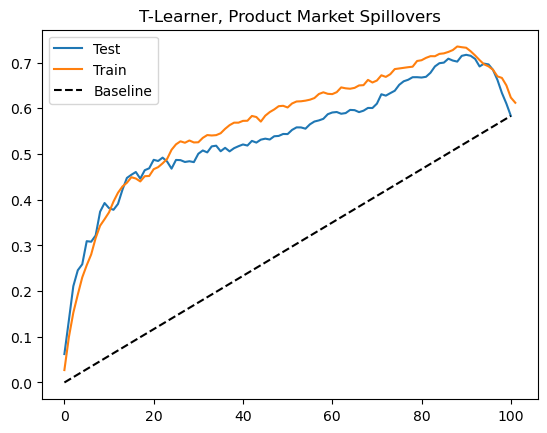

In [167]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner, Product Market Spillovers");

plt.savefig('t-learner_sic.png', bbox_inches='tight')

# X-Learner

In [168]:
# Helper fcn for standardizing data for PS model

def std_col(column):
    mean = column.mean()
    stdev = column.std()
    std_column = (column - mean)/stdev

    return std_column

def standardize_df(df, columns: list):
    new_df = df.copy()
    for col in columns:
        new_df[col] = std_col(new_df[col])

    return new_df

def ps_predict(df, t): 
    return g.predict_proba(df[X + ind_fes + yr_fes])[:, t]

In [169]:
# X-Learner
y = 'rmkvaf'
X = ['gspillsicIV','pat_count','rxrd','rsales','rppent','emp']
T = 'tec_abv_qtle'

# first stage models
m0 = RF(max_features=12, max_depth=16, random_state=0)
m1 = RF(max_features=12, max_depth=16, random_state=0)

# propensity score model
# try scaling data to help convergence of LR model
cols_to_scale = [X + [y,'gspilltecIV']]
train_scaled = standardize_df(train, cols_to_scale)
test_scaled = standardize_df(test, cols_to_scale)

g = LogisticRegression(solver="lbfgs", penalty=None, max_iter=2000) 

m0.fit(train_scaled.query('tec_abv_qtle==0')[X + ind_fes + yr_fes], train_scaled.query('tec_abv_qtle==0')[y])
m1.fit(train_scaled.query('tec_abv_qtle==1')[X + ind_fes + yr_fes], train_scaled.query('tec_abv_qtle==1')[y])
                       
g.fit(train_scaled[X + ind_fes + yr_fes], train_scaled[T]);

In [170]:
d_train = np.where(train_scaled[T]==0,
                   m1.predict(train_scaled[X + ind_fes + yr_fes]) - train_scaled[y],
                   train_scaled[y] - m0.predict(train_scaled[X + ind_fes + yr_fes]))

# second stage
mx0 = LGBMRegressor(max_depth=8, min_child_samples=30, verbose=-1)
mx1 = LGBMRegressor(max_depth=8, min_child_samples=30, verbose=-1)

mx0.fit(train_scaled.query(f"{T}==0")[X + ind_fes + yr_fes], d_train[train_scaled[T]==0])
mx1.fit(train_scaled.query(f"{T}==1")[X + ind_fes + yr_fes], d_train[train_scaled[T]==1]);

In [171]:

    
x_cate_train = (ps_predict(train_scaled,1)*mx0.predict(train_scaled[X + ind_fes + yr_fes]) +
                ps_predict(train_scaled,0)*mx1.predict(train_scaled[X + ind_fes + yr_fes]))

x_cate_test = test_scaled.assign(cate=(ps_predict(test_scaled,1)*mx0.predict(test_scaled[X + ind_fes + yr_fes]) +
                                ps_predict(test_scaled,0)*mx1.predict(test_scaled[X + ind_fes + yr_fes])))

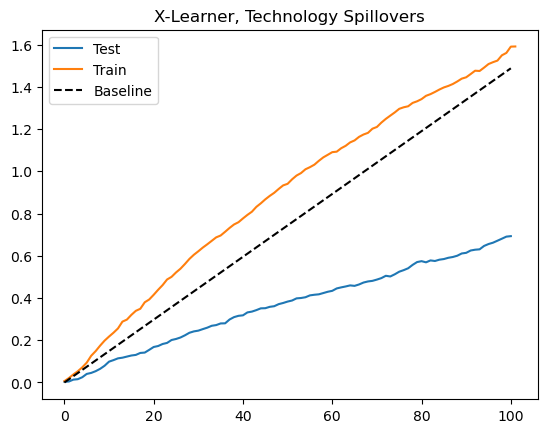

In [172]:
# Plot gain curve
gain_curve_test = cumulative_gain(x_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner, Technology Spillovers");

plt.savefig('x-learner_tec.png', bbox_inches='tight')

## Product Market Spillovers

In [173]:
y = 'rmkvaf'
X = ['gspilltecIV','pat_count','rxrd','rsales','rppent','emp']
T = 'sic_abv_qtle'

In [174]:
# X-Learner

# first stage models
m0 = RF(max_features=12, max_depth=16, random_state=0)
m1 = RF(max_features=12, max_depth=16, random_state=0)

g = LogisticRegression(solver="lbfgs", penalty=None, max_iter=2000) 

m0.fit(train_scaled.query('tec_abv_qtle==0')[X + ind_fes + yr_fes], train_scaled.query('tec_abv_qtle==0')[y])
m1.fit(train_scaled.query('tec_abv_qtle==1')[X + ind_fes + yr_fes], train_scaled.query('tec_abv_qtle==1')[y])
                       
g.fit(train_scaled[X + ind_fes + yr_fes], train_scaled[T]);

In [175]:
d_train = np.where(train_scaled[T]==0,
                   m1.predict(train_scaled[X + ind_fes + yr_fes]) - train_scaled[y],
                   train_scaled[y] - m0.predict(train_scaled[X + ind_fes + yr_fes]))

# second stage
mx0 = LGBMRegressor(max_depth=8, min_child_samples=30, verbose=-1)
mx1 = LGBMRegressor(max_depth=8, min_child_samples=30, verbose=-1)

mx0.fit(train_scaled.query(f"{T}==0")[X + ind_fes + yr_fes], d_train[train_scaled[T]==0])
mx1.fit(train_scaled.query(f"{T}==1")[X + ind_fes + yr_fes], d_train[train_scaled[T]==1]);

In [176]:
x_cate_train = (ps_predict(train_scaled,1)*mx0.predict(train_scaled[X + ind_fes + yr_fes]) +
                ps_predict(train_scaled,0)*mx1.predict(train_scaled[X + ind_fes + yr_fes]))

x_cate_test = test_scaled.assign(cate=(ps_predict(test_scaled,1)*mx0.predict(test_scaled[X + ind_fes + yr_fes]) +
                                ps_predict(test_scaled,0)*mx1.predict(test_scaled[X + ind_fes + yr_fes])))

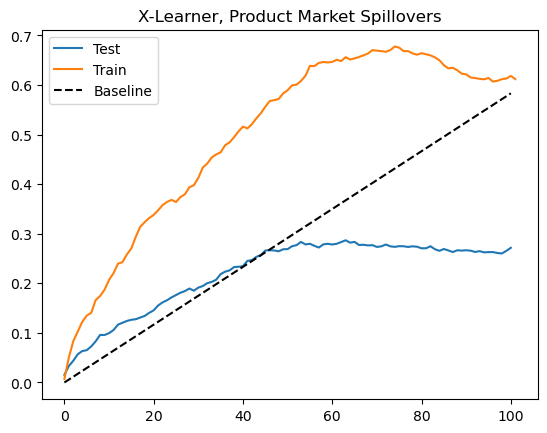

In [177]:
# Plot gain curve
gain_curve_test = cumulative_gain(x_cate_test, "cate", y=y, t=T)
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner, Product Market Spillovers");

plt.savefig('x-learner_sic.png', bbox_inches='tight')

# Double-Robust Model

In [190]:
# Doubly Robust Learner
from joblib import Parallel, delayed # for parallel processing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate


T = 'tec_abv_qtle'
X = ['pat_count', 'rxrd', 'rsales', 'rppent', 'emp','gspillsicIV']
y = 'rmkvaf'

# Define DR learner - from CIBT: 
# https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/12-Doubly-Robust-Estimation.ipynb

def doubly_robust(df, model, X, T, Y, return_ps=False):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1] # end of line: might need to switch 1 to 0 as it might be picking up 1-p(x)

    if type(model) == list:
        mu0 = model[0].fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
        mu1 = model[1].fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    
    else:
        mu0 = model.fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
        mu1 = model.fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])

    if return_ps == True:
        # get ps and treatment values for future graphing
        ps = pd.Series(ps).rename('ps')
        treat = df[T]
        treat_scores = pd.merge(treat, ps, left_index=True, right_index=True)
        return treat_scores
        
    else:
        return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

def doubly_robust_mse(df, model, X, T, Y):
    mse_mu0 = cross_validate(model, df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y],
                            scoring='neg_mean_squared_error', n_jobs=4)
    mse_mu0 = mse_mu0['test_score'].mean() # take mean of k=5 CV test errors
    
    mse_mu1 = cross_validate(model, df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y],
                            scoring='neg_mean_squared_error', n_jobs=4)
    mse_mu1 = mse_mu1['test_score'].mean()
    
    cols = ['model', 'T==1 error', 'T==0 error']
    vals = [[f'{model}', mse_mu1, mse_mu0]]
    results = pd.DataFrame(data=vals, columns=cols)

    return results



def bootstrap(df, samples, model, X, T, Y):
    bootstrap_sample = samples
    ates = Parallel(n_jobs=4)(delayed(doubly_robust)(df.sample(frac=0.3, replace=True), model, X, T, Y)
                              for _ in range(bootstrap_sample))
    ates = np.array(ates)
    return ates

In [191]:
# calculate ATE for winning model
models = [LGBMRegressor(max_depth=5, min_child_samples=30, verbose=-1), RF(max_depth=14, max_features=11, random_state=0, verbose=0)]
ate_tec = doubly_robust(train_scaled, models, X + ind_fes + yr_fes, T, y)
# Get treatments and prop scores for winning model
p_scores = doubly_robust(train_scaled, models, X + ind_fes + yr_fes, T, y, return_ps=True)


In [192]:
print(ate_tec)

-0.02371262130421182


In [193]:
# Get confidence interval
tec_bs = bootstrap(train_scaled, 100, models, X + ind_fes + yr_fes, T, y) # Get bootstrap CI's with 1000 iterations
ate_tec_h = np.percentile(tec_bs, 2.5) 
ate_tec_l = np.percentile(tec_bs, 97.5)

(array([ 4.,  0.,  4.,  7.,  5., 10., 17., 11., 10.,  4.,  8.,  4.,  5.,
         5.,  3.,  1.,  1.,  0.,  0.,  1.]),
 array([-0.06858794, -0.06184631, -0.05510468, -0.04836305, -0.04162141,
        -0.03487978, -0.02813815, -0.02139652, -0.01465488, -0.00791325,
        -0.00117162,  0.00557001,  0.01231165,  0.01905328,  0.02579491,
         0.03253655,  0.03927818,  0.04601981,  0.05276144,  0.05950308,
         0.06624471]),
 <BarContainer object of 20 artists>)

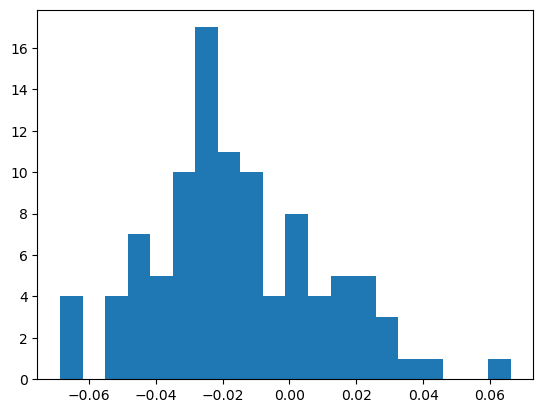

In [194]:
plt.hist(tec_bs, bins=20)

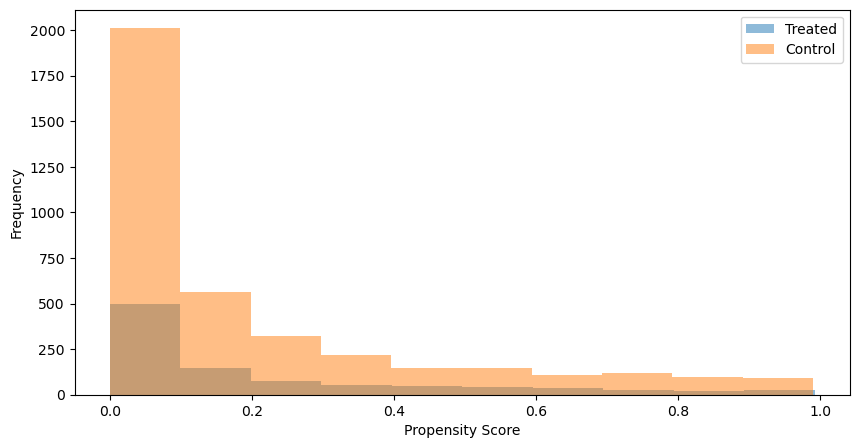

In [195]:
# plot graph
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.hist(p_scores.loc[p_scores[f'{T}']== 1, 'ps'], label='Treated', alpha=0.5)
ax1.hist(p_scores.loc[p_scores[f'{T}']== 0, 'ps'], label='Control', alpha=0.5)
ax1.legend()
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Propensity Score')
#ax1.set_title("Tech Spillovers")

plt.savefig('DRL_positivity_tec.png',bbox_inches='tight')

## Product Market Spillovers

In [196]:
# Again, but with product market spillovers
T = 'sic_abv_qtle'
X = ['pat_count', 'rxrd', 'rsales', 'rppent', 'emp','gspilltecIV']
y = 'rmkvaf'

In [197]:
# Get treatments and prop scores for winning model from testing suite
models = [LGBMRegressor(max_depth=5, min_child_samples=30),LGBMRegressor(max_depth=5, min_child_samples=30)]
ate_sic = doubly_robust(train_scaled, models, X + ind_fes + yr_fes, T, y)

p_scores = doubly_robust(train_scaled, models, X + ind_fes + yr_fes, T, y, return_ps=True)

In [198]:
print(ate_sic)

0.02031661098375541


In [199]:
# Get confidence interval
sic_bs = bootstrap(train_scaled, 100, models, X + ind_fes + yr_fes, T, y)
ate_sic_h = np.percentile(sic_bs, 2.5) 
ate_sic_l = np.percentile(sic_bs, 97.5)

(array([ 1.,  0.,  0.,  2.,  0.,  1.,  4.,  7.,  9.,  7.,  8.,  6., 10.,
        10., 11., 12.,  7.,  2.,  1.,  2.]),
 array([-0.060881  , -0.05383696, -0.04679292, -0.03974889, -0.03270485,
        -0.02566081, -0.01861677, -0.01157274, -0.0045287 ,  0.00251534,
         0.00955937,  0.01660341,  0.02364745,  0.03069149,  0.03773552,
         0.04477956,  0.0518236 ,  0.05886763,  0.06591167,  0.07295571,
         0.07999975]),
 <BarContainer object of 20 artists>)

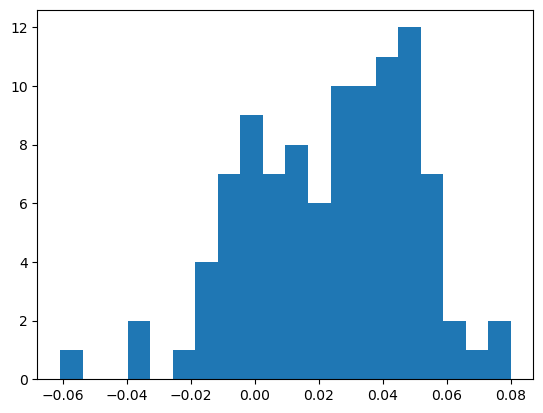

In [200]:
# plot ate distribution
plt.hist(sic_bs, bins=20)

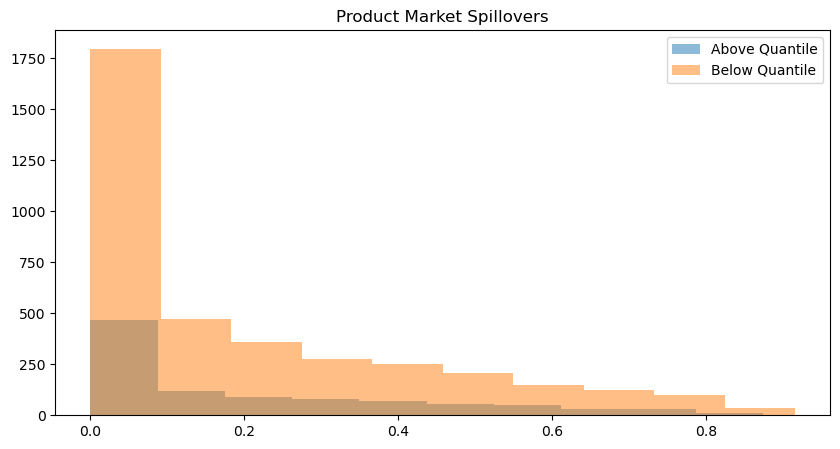

In [201]:
# plot graph
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.hist(p_scores.loc[p_scores[f'{T}']== 1, 'ps'], label='Above Quantile', alpha=0.5)
ax1.hist(p_scores.loc[p_scores[f'{T}']== 0, 'ps'], label='Below Quantile', alpha=0.5)
ax1.legend()
ax1.set_title("Product Market Spillovers")

plt.savefig('DRL_positivity_sic.png',bbox_inches='tight')

In [202]:
# # Get table of results for W9 report
# tec_data = ['Technology',ate_tec, ate_tec_l, ate_tec_h, ate_tec_ipw]
# sic_data = ['Product Market',ate_sic, ate_sic_l, ate_sic_h, ate_sic_ipw]

# w9_table = pd.DataFrame(data = [tec_data,sic_data], columns=['Spillover','Doubly Robust ATE', "CI_l", "CI_h", "IPW ATE"]).set_index('Spillover')

# #w9_table = w9_table.style.format(precision=2) # Round values to 2 decimals
# print(w9_table.to_latex())

# Double ML Models
## Linear DML

In [204]:
# Based on Ch 22 of CIBT

y = "rmkvaf"
T = 'gspilltecIV'
X = ['pat_count','rxrd','rsales','rppent','emp','gspillsicIV'] + ind_fes + yr_fes

# Get Train/Test split
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df_t.drop('rmkvaf', axis=1),
                                df_t['rmkvaf'],
                                test_size=0.3,
                                random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test,y_test], axis=1)

In [205]:
# Train Linear Model

# model for treatment (spillovers)
debias_m = RF(max_features=20, random_state=0, verbose=0)

train_pred = train.assign(spill_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5))

# model for outcome (market value)

denoise_m = RF(max_features=20, random_state=0, verbose=0)

train_pred = train_pred.assign(firmval_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5))

In [206]:
# get ATE
final_lmodel = smf.ols(formula='firmval_res ~ spill_res', data=train_pred).fit(cov_type='HC0')

final_lmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            firmval_res   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.319
Date:                Mon, 16 Dec 2024   Prob (F-statistic):             0.0377
Time:                        21:04:10   Log-Likelihood:                -9021.5
No. Observations:                9369   AIC:                         1.805e+04
Df Residuals:                    9367   BIC:                         1.806e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.007      1.353      0.176      -0.004       0.022
spill_res     -0.0334      0.016     -2.078      0.038      -0.065      -0.002
==============================================================================
Omnibus:                      888.435   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4412.525
Skew:                          -0.331   Prob(JB):                         0.00
Kurtosis:                       6.296   Cond. No.                         1.98
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [207]:
# estimate CATE
# get model with interactions between x's and treatment residual
final_model_cate = smf.ols(formula='firmval_res ~ spill_res * (pat_count + rxrd + rsales + rppent + emp + gspillsicIV + year + sic2)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(spill_res=1))
                        - final_model_cate.predict(test.assign(spill_res=0))) # spill_res is continuous and not binary but this works because
                                                                            # we are just trying to recover the slope of a conditional linear model.

print(cate_test['cate'].mean())

-0.10358076465261085


## Non-linear Model

In [208]:
# Helper function: Cumulative gain w/ y axis being cumulative ATE. Based on nb21

def cumulative_ate_gain(dataset, prediction, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([ordered_df.head(rows)[prediction].mean() * (rows/size) for rows in n_rows])

In [215]:
# create the weights
w = train_pred["spill_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["firmval_res"] / train_pred["spill_res"]) #Y tilde / T tilde

# merge to train data for use in bootstrapping
train['weight'] = w
train['y_star'] = y_star

In [216]:
# Train Non-linear Model

final_nlmodel = LGBMRegressor(max_depth=1, min_child_samples=90, verbose=-1) # Lowest MSE of the non-linear models

# use a weighted regression ML model to predict the target with the weights.
final_nlmodel.fit(X=train[X], y=y_star, sample_weight=w); # regressing on y tilde/ t tilde over X set

# get ATE via individual effects
cate_test_non_param = test.assign(cate=final_nlmodel.predict(test[X]))

ate_non_param = cate_test_non_param['cate'].mean()
print(ate_non_param)

-0.07677254845983343


In [217]:
# Get bootstrapped CI's
def bootstrap_nldml(train_data, test_data, model, X, y, weight, samples:int):
    results=[]
    for i in range(0,samples):
        train_sample = train_data.sample(frac=0.3, replace=True)
        test_sample = test_data.sample(frac=0.3, replace=True)
        model.fit(X=train_sample[X], y=train_sample[y], sample_weight=train_sample[weight])

        cates = test_sample.assign(cate=model.predict(test_sample[X]))
        ate = cates['cate'].mean()
        results.append(ate)
    return results


(array([ 2.,  3.,  8., 13., 20., 26., 21.,  4.,  1.,  2.]),
 array([-0.17005407, -0.15199932, -0.13394456, -0.1158898 , -0.09783505,
        -0.07978029, -0.06172553, -0.04367077, -0.02561602, -0.00756126,
         0.0104935 ]),
 <BarContainer object of 10 artists>)

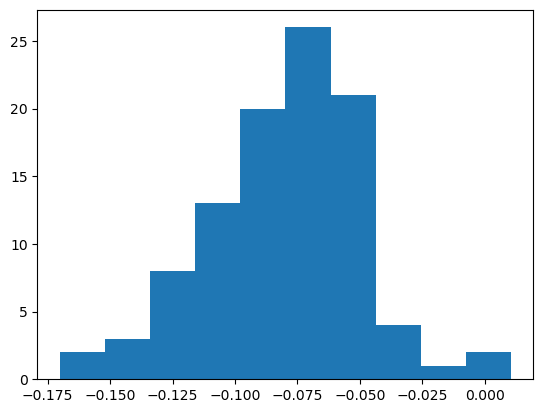

In [218]:
bs_tec = bootstrap_nldml(train, test, final_nlmodel, X=X, y='y_star', weight='weight', samples=100)
plt.hist(bs_tec)

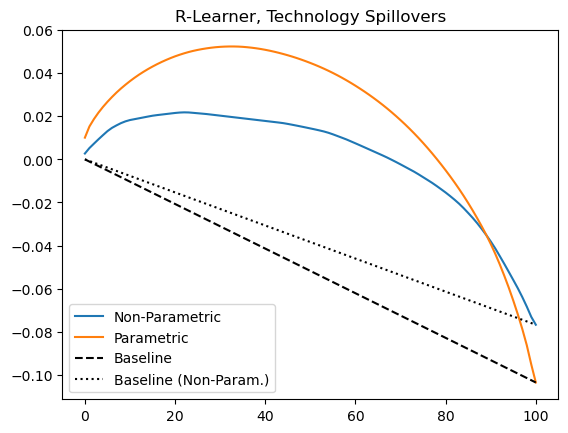

In [219]:
# Report results

# gain curve
# gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
# gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
gain_curve_test = cumulative_ate_gain(cate_test, "cate")
gain_curve_test_non_param = cumulative_ate_gain(cate_test_non_param, "cate")

plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, cate_test['cate'].mean()], linestyle="--", color="black", label="Baseline")
plt.plot([0, 100], [0, cate_test_non_param['cate'].mean()], linestyle=":", color="black", label="Baseline (Non-Param.)")
plt.legend();
plt.title("R-Learner, Technology Spillovers");

plt.savefig("DML_gaincurve_tec.png", bbox_inches='tight')

## Product Market Spillovers

In [220]:
T = 'gspillsicIV'
X = ['pat_count','rxrd','rsales','rppent','emp','gspilltecIV'] + ind_fes + yr_fes
y = 'rmkvaf'

In [221]:
# Train Linear Model

# model for treatment (spillovers)
debias_m = RF(max_features=20, random_state=0, verbose=0)

train_pred = train.assign(spill_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5))

# model for outcome (market value)

denoise_m = RF(max_features=20, random_state=0, verbose=0)

train_pred = train_pred.assign(firmval_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5))

In [222]:
# get ATE
final_lmodel = smf.ols(formula='firmval_res ~ spill_res', data=train_pred).fit(cov_type='HC0')

final_lmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            firmval_res   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.661
Date:                Mon, 16 Dec 2024   Prob (F-statistic):            0.00987
Time:                        21:17:53   Log-Likelihood:                -9132.8
No. Observations:                9369   AIC:                         1.827e+04
Df Residuals:                    9367   BIC:                         1.828e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0109      0.007      1.640      0.101      -0.002       0.024
spill_res      0.0244      0.009      2.581      0.010       0.006       0.043
==============================================================================
Omnibus:                      817.944   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3792.746
Skew:                          -0.308   Prob(JB):                         0.00
Kurtosis:                       6.056   Cond. No.                         1.24
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [223]:
# estimate CATE
# get model with interactions between x's and treatment residual
final_model_cate = smf.ols(formula='firmval_res ~ spill_res * (pat_count + rxrd + rsales + rppent + emp + gspilltecIV + year + sic2)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(spill_res=1))
                        - final_model_cate.predict(test.assign(spill_res=0))) # spill_res is continuous and not binary but this works because
                                                                            # we are just trying to recover the slope of a conditional linear model.

print(cate_test['cate'].mean())

0.027520792752511725


## Non-linear Model

In [225]:
# create the weights
w = train_pred["spill_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["firmval_res"] / train_pred["spill_res"]) #Y tilde / T tilde

# merge to train data for use in bootstrapping
train['weight'] = w
train['y_star'] = y_star

In [226]:
# Train Non-linear Model

final_nlmodel = LGBMRegressor(max_depth=1, min_child_samples=90, verbose=-1) # Lowest MSE of the non-linear models

# use a weighted regression ML model to predict the target with the weights.
final_nlmodel.fit(X=train[X], y=y_star, sample_weight=w); # regressing on y tilde/ t tilde over X set

# get ATE via individual effects
cate_test_non_param = test.assign(cate=final_nlmodel.predict(test[X]))

In [227]:
ate_non_param = cate_test_non_param['cate'].mean()
print(ate_non_param)

0.026934105256252186


(array([ 4., 11., 17., 23., 16., 17.,  7.,  4.,  0.,  1.]),
 array([-0.01283402, -0.003043  ,  0.00674802,  0.01653904,  0.02633006,
         0.03612108,  0.0459121 ,  0.05570312,  0.06549413,  0.07528515,
         0.08507617]),
 <BarContainer object of 10 artists>)

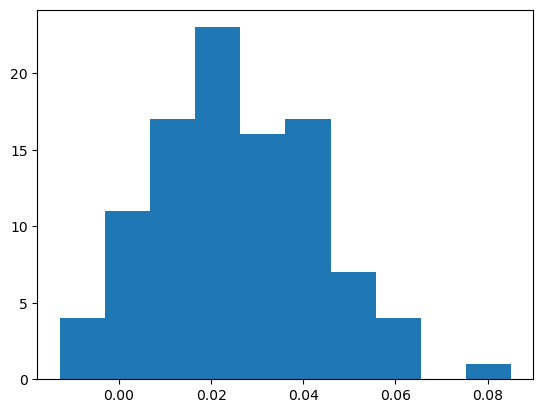

In [229]:
# bootstrap CIs
bs_sic = bootstrap_nldml(train, test, final_nlmodel, X=X, y='y_star', weight='weight', samples=100)
plt.hist(bs_sic)

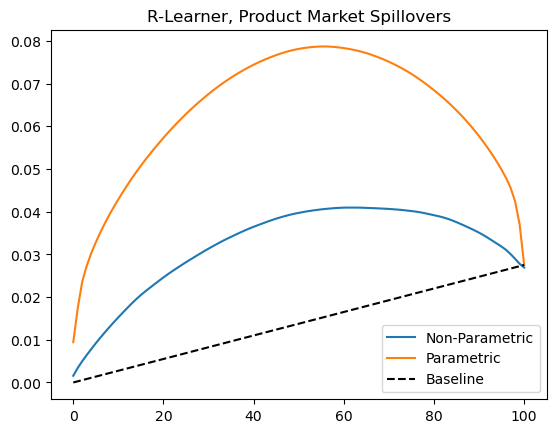

In [231]:
# Report results

# gain curve
# gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
# gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
gain_curve_test = cumulative_ate_gain(cate_test, "cate")
gain_curve_test_non_param = cumulative_ate_gain(cate_test_non_param, "cate")

plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, cate_test['cate'].mean()], linestyle="--", color="black", label="Baseline")
#plt.plot([0, 100], [0, cate_test_non_param['cate'].mean()], linestyle=":", color="black", label="Baseline (Non-Param.)")
plt.legend();
plt.title("R-Learner, Product Market Spillovers");

plt.savefig("DML_gaincurve_sic.png", bbox_inches='tight')

# Data Simulations

In [137]:
# Simulate patent count data

# define functions - taken from CIBT CH 22

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = skm.KFold(n_splits=n_splits)    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models # return cross-validated predictions of y given X


def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0) # return across-model average prediction


In [142]:
y = "rmkvaf"
T = 'gspilltecIV'
X = ['pat_count','rxrd','rsales','rppent','emp','gspillsicIV'] + ind_fes + yr_fes

# Make models for CATE predictions

y_hat, models_y = cv_estimate(train, 5, RF, dict(max_features=20, random_state=0, verbose=0), X, y)
t_hat, models_t = cv_estimate(train, 5, RF, dict(max_features=20, random_state=0, verbose=0), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

In [153]:
model_final = LGBMRegressor(max_depth=17, min_child_samples=30)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

In [154]:
# simulate data

pred_test = (test
             .rename(columns={"pat_count":"factual_patcount"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, pat_count=np.linspace(0, 30, 31))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==2760")

index       i  year      rxrd     gspillsic     gspilltec  \
66588   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66589   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66590   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66591   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66592   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66593   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66594   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66595   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66596   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66597   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66598   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66599   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66600   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66601   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66602   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66603   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66604   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66605   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66606   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66607   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66608   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66609   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66610   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66611   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66612   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66613   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66614   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66615   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66616   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66617   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66618   2760  3796.0  1993  0.724295  32559.734375  23035.136719   

       factual_patcount    rsales    rppent       emp  ...  yr_1998  yr_1999  \
66588               2.0  4.178773  2.621716  0.297137  ...        0        0   
66589               2.0  4.178773  2.621716  0.297137  ...        0        0   
66590               2.0  4.178773  2.621716  0.297137  ...        0        0   
66591               2.0  4.178773  2.621716  0.297137  ...        0        0   
66592               2.0  4.178773  2.621716  0.297137  ...        0        0   
66593               2.0  4.178773  2.621716  0.297137  ...        0        0   
66594               2.0  4.178773  2.621716  0.297137  ...        0        0   
66595               2.0  4.178773  2.621716  0.297137  ...        0        0   
66596               2.0  4.178773  2.621716  0.297137  ...        0        0   
66597               2.0  4.178773  2.621716  0.297137  ...        0        0   
66598               2.0  4.178773  2.621716  0.297137  ...        0        0   
66599               2.0  4.178773  2.621716  0.297137  ...        0        0   
66600               2.0  4.178773  2.621716  0.297137  ...        0        0   
66601               2.0  4.178773  2.621716  0.297137  ...        0        0   
66602               2.0  4.178773  2.621716  0.297137  ...        0        0   
66603               2.0  4.178773  2.621716  0.297137  ...        0        0   
66604               2.0  4.178773  2.621716  0.297137  ...        0        0   
66605               2.0  4.178773  2.621716  0.297137  ...        0        0   
66606               2.0  4.178773  2.621716  0.297137  ...        0        0   
66607               2.0  4.178773  2.621716  0.297137  ...        0        0   
66608               2.0  4.178773  2.621716  0.297137  ...        0        0   
66609               2.0  4.178773  2.621716  0.297137  ...        0   

In [155]:
t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==2760")

index       i  year      rxrd     gspillsic     gspilltec  \
66588   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66589   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66590   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66591   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66592   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66593   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66594   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66595   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66596   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66597   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66598   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66599   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66600   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66601   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66602   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66603   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66604   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66605   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66606   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66607   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66608   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66609   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66610   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66611   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66612   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66613   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66614   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66615   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66616   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66617   2760  3796.0  1993  0.724295  32559.734375  23035.136719   
66618   2760  3796.0  1993  0.724295  32559.734375  23035.136719   

       factual_patcount    rsales    rppent       emp  ...  yr_1999  yr_2000  \
66588               2.0  4.178773  2.621716  0.297137  ...        0        0   
66589               2.0  4.178773  2.621716  0.297137  ...        0        0   
66590               2.0  4.178773  2.621716  0.297137  ...        0        0   
66591               2.0  4.178773  2.621716  0.297137  ...        0        0   
66592               2.0  4.178773  2.621716  0.297137  ...        0        0   
66593               2.0  4.178773  2.621716  0.297137  ...        0        0   
66594               2.0  4.178773  2.621716  0.297137  ...        0        0   
66595               2.0  4.178773  2.621716  0.297137  ...        0        0   
66596               2.0  4.178773  2.621716  0.297137  ...        0        0   
66597               2.0  4.178773  2.621716  0.297137  ...        0        0   
66598               2.0  4.178773  2.621716  0.297137  ...        0        0   
66599               2.0  4.178773  2.621716  0.297137  ...        0        0   
66600               2.0  4.178773  2.621716  0.297137  ...        0        0   
66601               2.0  4.178773  2.621716  0.297137  ...        0        0   
66602               2.0  4.178773  2.621716  0.297137  ...        0        0   
66603               2.0  4.178773  2.621716  0.297137  ...        0        0   
66604               2.0  4.178773  2.621716  0.297137  ...        0        0   
66605               2.0  4.178773  2.621716  0.297137  ...        0        0   
66606               2.0  4.178773  2.621716  0.297137  ...        0        0   
66607               2.0  4.178773  2.621716  0.297137  ...        0        0   
66608               2.0  4.178773  2.621716  0.297137  ...        0        0   
66609               2.0  4.178773  2.621716  0.297137  ...        0   

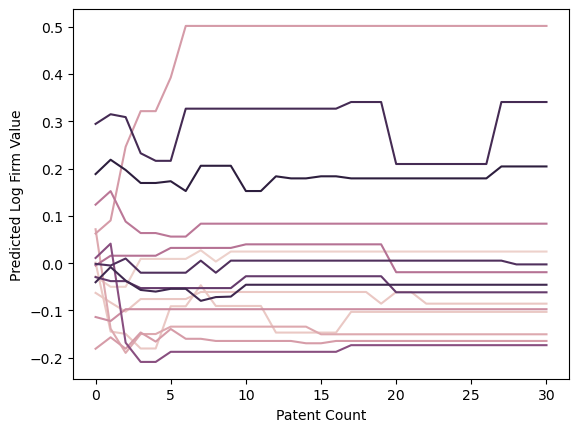

In [156]:
# Plot sample units firm value wrt patent count
import seaborn as sns

np.random.seed(8)
sample_ids = np.random.choice(pred_test["index"].unique(), 15)

sim_plot = sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="pat_count", y="rmkvaf_pred", hue="index", legend=False);

sim_plot.set(xlabel="Patent Count", ylabel="Predicted Log Firm Value")

sim_plot = sim_plot.get_figure()
sim_plot.savefig('sim_plot.png')

# Generalized Random Forest

In [84]:
# define outcome, covariates, treatment and instrument
X = ['pat_count','rxrd','rsales','rppent','emp', 'gspillsicIV'] + ind_fes + yr_fes
T = "gspilltecIV"
y = "rmkvaf"
# Z = "gspilltecIV" # no instrument - gspilltecIV is spillovers explained by tax cred's i.e. first stage already done

# Get Train/Test split
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(df_t[X + [T]],
                                df_t[y],
                                test_size=0.3,
                                random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test,y_test], axis=1)

In [85]:
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [86]:
est.fit(train[X], train[T], train[y])

CausalForest(criterion='het', min_impurity_decrease=0.001, min_samples_leaf=40,
             min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
             n_estimators=400, random_state=123)

In [87]:
# Gen predictions on test set
point, lb, ub = est.predict(X_test[X], interval=True, alpha=0.01)

# Get predictions on full sample for graphing later
df_t['hte_tec'] = est.predict(df_t[X], interval=False)

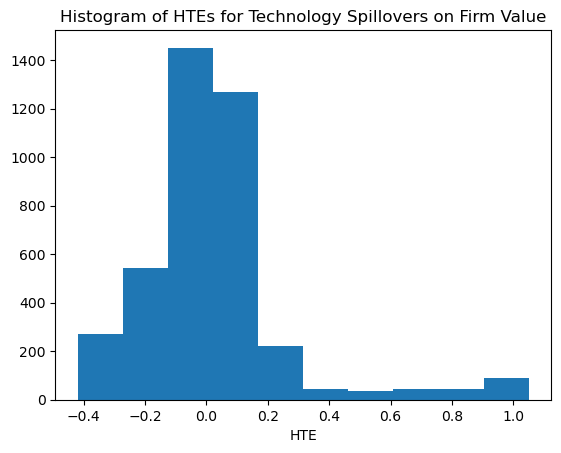

In [88]:
# Make histogram of HTES
fig, ax = plt.subplots()

ax.hist(point)
ax.set_xlabel("HTE")
ax.set_title("Histogram of HTEs for Technology Spillovers on Firm Value")

plt.savefig("htes_tec.png", bbox_inches='tight')

## Product Market Spillovers

In [89]:
# define outcome, covariates, treatment
X = ['pat_count','rxrd','rsales','rppent','emp', 'gspilltecIV'] + ind_fes + yr_fes
T = "gspillsicIV"
y = "rmkvaf"

In [90]:
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [91]:
est.fit(train[X], train[T], train[y])

CausalForest(criterion='het', min_impurity_decrease=0.001, min_samples_leaf=40,
             min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
             n_estimators=400, random_state=123)

In [92]:
# Gen predictions on test set
point, lb, ub = est.predict(X_test[X], interval=True, alpha=0.01)

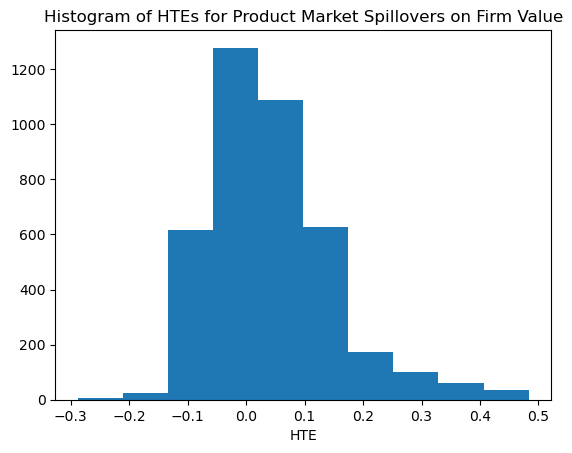

In [93]:
# Make histogram of HTES
fig, ax = plt.subplots()

ax.hist(point)
ax.set_xlabel("HTE")
ax.set_title("Histogram of HTEs for Product Market Spillovers on Firm Value")

plt.savefig("htes_sic.png", bbox_inches='tight')

In [94]:
# OPTIONAL FOR REPORT BUT REQ'D FOR P2: Visualize HTE on subparts of data: patents(0, >0)? year? Both?

In [101]:
# Get HTEs for full sample
df_t['hte_sic'] = est.predict(df_t[X], interval=False)

In [96]:
# create five-year categories
def set_5yr_cat (x):
    if x in ['1980','1981','1982','1983','1984']:
        return '1980-84'
    elif x in ['1985','1986','1987','1988','1989']:
        return '1985-89'
    elif x in ['1990','1991','1992','1993','1994']:
        return '1990-94'
    elif x in ['1995','1996','1997','1998','1999']:
        return '1995-99'
    elif x in ['2000','2001']:
        return '2000-01'
    else:
        return np.nan

df_t['year5'] = df_t['year'].apply(set_5yr_cat)

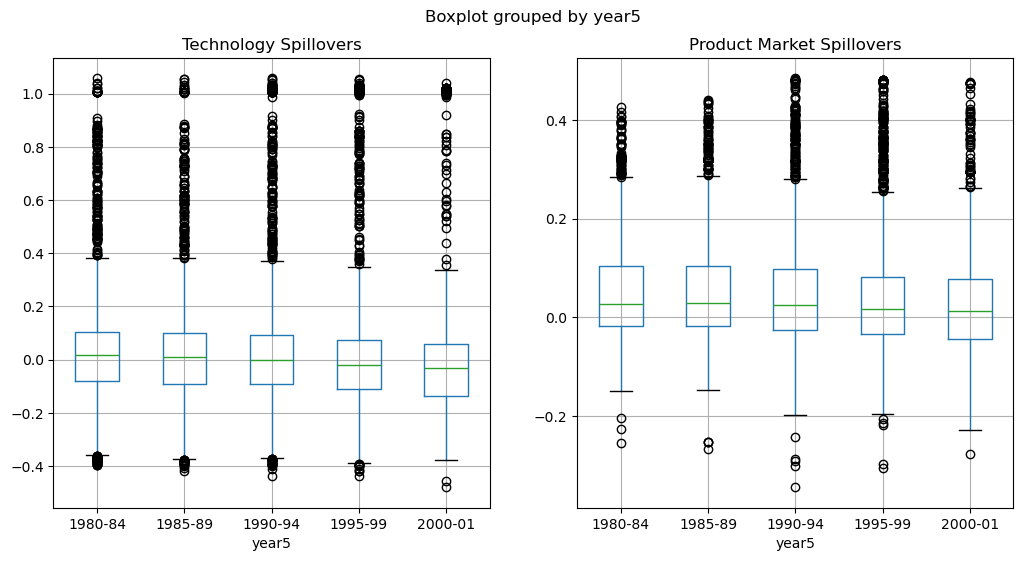

In [102]:
# Graph boxplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
df_t.boxplot(column='hte_tec', by='year5', ax=axs[0])
axs[0].set_title('Technology Spillovers')

df_t.boxplot(column='hte_sic', by='year5', ax=axs[1])
axs[1].set_title('Product Market Spillovers')

plt.show()

# DAG model and testing

In [63]:
# From implementation in Causal Discovery in Python

DAG3 = """graph [
directed 1

node [
    id 0
    label "rmkvaf"
    graphics [
        fill 
    ]
    ]

node [
    id 1
    label "rxrd"
    ]
    
node [
    id 2
    label "rsales"
    ]

node [
    id 3
    label "gspilltecIV"
    ]

node [
    id 4
    label "gspillsicIV"
    ]

node [
    id 5
    label "pat_count"
    ]

node [
    id 7
    label "rppent"
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 5
    target 7
    ]


edge [
    source 3
    target 1
    ]


edge [
    source 4
    target 1
    ]


edge [
    source 4
    target 2
    ]


edge [
    source 1
    target 7
    ]


edge [
    source 1
    target 5
    ]


edge [
    source 7
    target 2
    ]


edge [
    source 2
    target 0
    ]

edge [
    source 7
    target 0
    ]

]
    
    """

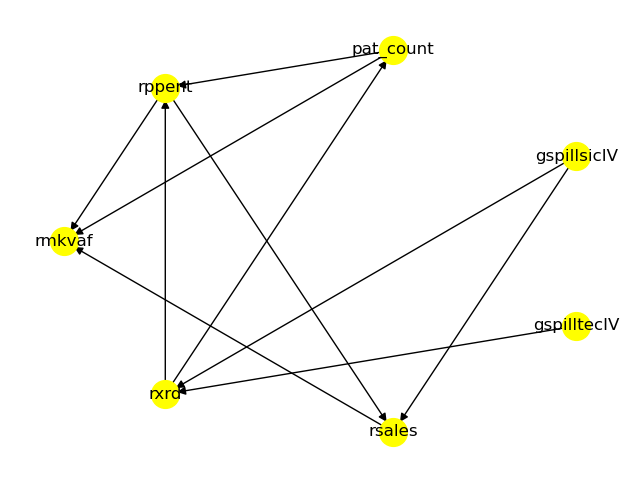

In [64]:
model = CausalModel(
    data=df,
    treatment='gspilltecIV',
    outcome='rmkvaf',
    graph=DAG3)

model.view_model()

In [65]:
# identify estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[rmkvaf])
d[gspilltecIV]           
Estimand assumption 1, Unconfoundedness: If U→{gspilltecIV} and U→rmkvaf then P(rmkvaf|gspilltecIV,,U) = P(rmkvaf|gspilltecIV,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [66]:
# obtain estimates
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(estimate.value)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
0.12296998685337712


In [67]:
# refutation test
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

print(refute_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['gspillsicIV']}
{'control_value

# Model Testing Suite

In [150]:
import time
start_time = time.time() # track runtime

feature_n = np.linspace(30, 300, num=10, dtype=int)
#max_depth_n = np.linspace(1,20, num=20, dtype=int)

test_df1 = pd.DataFrame(data={'min_child_samples': feature_n})
#test_df2 = pd.DataFrame(data={'max_depth_n': max_depth_n})

# model_mse = test_df1.merge(test_df2, how='cross')
model_mse = test_df1
model_mse['test_mse'] = np.nan

# SPECIFY X's AND Y
testing_X = train[X].assign(**{T: t_res})
testing_Y = y_res

## Two-dimensional tuning
# for i in feature_n:
#     for j in max_depth_n:
#         model = RF(max_features=i, max_depth=j, random_state=0, verbose=0)
#         mse = skm.cross_val_score(model, testing_X, testing_Y, cv=5, scoring='neg_mean_squared_error').mean()
#         model_mse.loc[(model_mse['feature_n'] == i) & (model_mse['max_depth_n'] == j ), 'test_mse'] = mse

# One-dimensional tuning
for i in feature_n:
    model = LGBMRegressor(max_depth=17, min_child_samples=i, verbose=-1)
    mse = skm.cross_val_score(model, testing_X, testing_Y, cv=5, scoring='neg_mean_squared_error').mean()
    model_mse.loc[(model_mse['min_child_samples'] == i), 'test_mse'] = mse

min_mse = max(model_mse['test_mse']) # max because MSEs are given as negatives
model_mse.loc[model_mse['test_mse'] == min_mse]

skm.cross_val_score(model, train[X], train[T], cv=5, scoring='neg_mean_squared_error')

run_time = time.time() - start_time
print(f"Total Runtime: {run_time/60} minutes")

Total Runtime: 0.07611353000005086 minutes


In [151]:
model_mse

min_child_samples  test_mse
0                 30 -0.377265
1                 60 -0.381376
2                 90 -0.383285
3                120 -0.386553
4                150 -0.387869
5                180 -0.388284
6                210 -0.388866
7                240 -0.389921
8                270 -0.389934
9                300 -0.392644

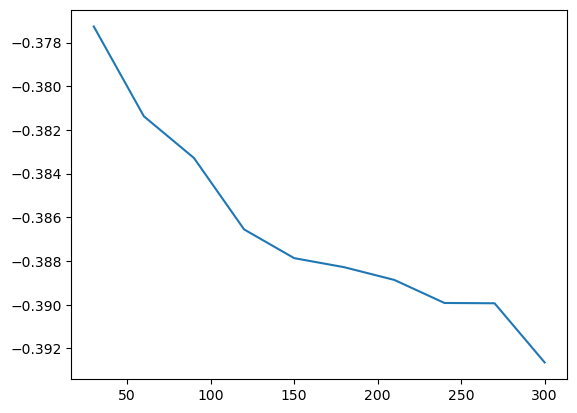

In [152]:
# plot mses
plt.plot(model_mse['min_child_samples'],model_mse['test_mse'])

In [ ]:
# max_feat = 2 best for RF. max depth 1 for LGBM